This notebook curates a benchmark dataset of paired antibody variable domains (VH/VL) starting from SAbDab exports and PDB mmCIF files.
All file paths are relative to `ROOT` and the notebook is designed to be rerunnable end-to-end.

In [67]:
from __future__ import annotations
from pathlib import Path
import json
import pandas as pd
import numpy as np
import re, math, os, io, sys, contextlib, gzip, time
from datetime import datetime 
import gemmi
os.environ.setdefault("ANARCI_SILENT", "1")
from anarci import run_anarci
import requests
import shutil, subprocess, tempfile
from collections.abc import Iterable
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from collections import deque
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Any, Dict, List, Tuple, Optional
from IPython.display import display
import hashlib
import zipfile
from pandas.errors import EmptyDataError
from contextlib import contextmanager, redirect_stdout, redirect_stderr
import importlib.util

In [68]:
MAX_RESOLUTION_XRAY = 3.0
ALLOW_CRYO_EM = False
INCLUDE_NANOBODIES = False
REQUIRE_PAIRED = True
CHOTHIA_ONLY: bool = True
STRICT_ANARCI_ONLY: bool = True

Inputs:
- `data/raw/sabdab/` : SAbDab summary exports (attribute summary + non-redundant summary)
- `data/raw/pdb_mmcif/` : downloaded mmCIF structures (source of truth for sequences/coordinates)

Outputs:
- `data/processed/manifest/` : sample sheets / indexes used to run predictors (stable identifiers)
- `data/processed/exports/` : curated tables used for analysis + QC summaries
- `data/processed/qc/` : validation artifacts and failure logs

In [69]:
ROOT = Path("..").resolve()
RAW_DIR = ROOT / "data/raw/sabdab"
SABDAB_ATTR_SUMMARY_TSV = RAW_DIR / "20251125_0085698_summary.tsv"
SABDAB_NR_SUMMARY_TSV = RAW_DIR / "20251125_0272607_summary.tsv"
MMCIF_DIR = ROOT / "data/raw/pdb_mmcif"
MAN_DIR = ROOT / "data/processed/manifest"
EXP_DIR = ROOT / "data/processed/exports"
PLOTS_DIR = EXP_DIR / "plots"
QC_DIR = ROOT / "data/processed/qc"
MMCIF_VALID_DIR = QC_DIR / "mmcif_validation"

for d in [RAW_DIR, MMCIF_DIR, MAN_DIR, EXP_DIR, PLOTS_DIR, QC_DIR, MMCIF_VALID_DIR]:
    d.mkdir(parents=True, exist_ok=True)

SAMPLE_SHEET       = MAN_DIR / "sample_sheet.csv"
PAIRS_AF3_INDEX    = MAN_DIR / "pairs_af3.csv"
PAIRS_INDEX        = MAN_DIR / "pairs_index.csv"
PAIRS_WITHSEQS     = MAN_DIR / "pairs_withseqs.csv"

QC_FAILS_CSV = EXP_DIR / "qc_failures.csv"
PAIRS_QC_PASS_CSV = EXP_DIR / "pairs_qc_pass.csv"
PAIRS_QC_FAIL_CSV = EXP_DIR / "pairs_qc_fail.csv"
PAIRS_QC_PASS_ULTRA_CSV = EXP_DIR / "pairs_qc_pass_ultrashort_pruned"
WITHIN_PDB_EXACT_CSV = EXP_DIR / "within_pdb_exact.csv"
WITHIN_PDB_NEAR95_CSV = EXP_DIR / "within_pdb_near95.csv"
AA_COMPOSITION_CSV = EXP_DIR / "aa_composition.csv"
FV90_TSV = EXP_DIR / "fv90.tsv"
FV90_REPS_CSV = EXP_DIR / "fv_pairs_nonredundant_90.csv"
FV90_SUMMARY_CSV = EXP_DIR / "redundancy_summary_fv90.csv"
CLUSTER_MEMBERSHIP_CSV = EXP_DIR / "cluster_membership_fv90.csv"
CLUSTER_SUMMARY_CSV = EXP_DIR / "cluster_summary_fv90.csv"
REDUNDANCY_ONE_LINER_CSV= EXP_DIR / "redundancy_one_liner.csv"
APPENDIX_METRICS_TXT = EXP_DIR / "appendix_metrics.txt"
APPENDIX_REPORT_MD = EXP_DIR / "appendix_report.md"

AA_COMPOSITION_PNG = PLOTS_DIR / "aa_composition.png"
LIGHT_TYPE_COUNTS_PNG = PLOTS_DIR / "light_type_counts_labeled.png"
H3_LENGTH_HIST_PNG = PLOTS_DIR / "h3_length_hist.png"

MANIFEST = SAMPLE_SHEET
MANIFEST_AF3 = PAIRS_AF3_INDEX
PAIRS_IDS = PAIRS_INDEX
WITH_SEQS = PAIRS_WITHSEQS
PAIRS_WITHSEQS_QC = EXP_DIR / "pairs_withseqs_qc.csv"
PAIRS_QC_CSV = PAIRS_QC_PASS_CSV
PAIRS_QC_FAIL = PAIRS_QC_FAIL_CSV
PAIRS_FINAL = PAIRS_QC_PASS_ULTRA_CSV
EXACT_WITHIN_PDB = WITHIN_PDB_EXACT_CSV
NEAR95_WITHIN_PDB = WITHIN_PDB_NEAR95_CSV
AA_COMP = AA_COMPOSITION_CSV
FV90_REPS = FV90_REPS_CSV
FV90_SUMMARY = FV90_SUMMARY_CSV
APPENDIX_MD = APPENDIX_REPORT_MD

NULL_TOKENS = {"", "NA", "N/A", "NONE", "NAN", "NULL", "<NA>"}

def is_null_token(x) -> bool:
    if pd.isna(x):
        return True
    s = str(x).strip()
    return s.upper() in NULL_TOKENS

In [70]:
NOTEBOOK_DIR = Path.cwd()
ANARCI_PATH = NOTEBOOK_DIR / "ANARCI.py"

if not ANARCI_PATH.exists():
    raise FileNotFoundError(f"Expected ANARCI.py at: {ANARCI_PATH}")

spec = importlib.util.spec_from_file_location("ANARCI_local", str(ANARCI_PATH))
ANARCI_local = importlib.util.module_from_spec(spec)
sys.modules["ANARCI_local"] = ANARCI_local
spec.loader.exec_module(ANARCI_local)


from ANARCI_local import (
    annotate_cdrs_anarci,
    run_and_collect,
    triples_to_seq,
    cdr_slice_from_triples,
    aa_clean,
    get_numbered_span,
    extract_v_domain_anarci_only,
)

We filter SAbDab entries to build a fair benchmark in relations to IgFold, ABodyBuilder2, and AlphaFold3:
- Experimental method: X-ray diffraction only
- Resolution: ≤ 3.0 Å
- Require paired VH/VL chains
- Exclusion of nanobodies (single-domain antibodies)

In [71]:
def parse_float_angstrom(x):
    try:
        s = str(x).strip().replace("Å","")
        return float(s.split()[0])
    except Exception:
        return float("nan")

def parse_deposition_date(s):
    if pd.isna(s): return pd.NaT
    s = str(s).strip()
    fmts = ("%Y-%m-%d","%d/%m/%Y","%m/%d/%Y","%Y/%m/%d",
            "%d-%b-%Y","%m/%d/%y","%d/%m/%y")
    for f in fmts:
        try:
            dt = datetime.strptime(s, f)
            if f.endswith("%y") and dt.year < 1970:
                dt = dt.replace(year=dt.year + 100)
            return pd.to_datetime(dt)
        except Exception:
            pass
    return pd.to_datetime(s, errors="coerce")

def load_csv_or_tsv(p: Path) -> pd.DataFrame:
    try:
        return pd.read_csv(p, low_memory=False)
    except Exception:
        return pd.read_csv(p, sep="\t", low_memory=False)

MAP_NR = {
    "pdb": "pdb",
    "Hchain": "Hchain",
    "Lchain": "Lchain",
    "method": "method",
    "resolution": "resolution",
    "date": "date",
    "antigen_type": "antigen_type",
    "antigen_chain": "antigen_chain",
    "organism": "organism",
    "heavy_species": "heavy_species",
    "light_species": "light_species",
}
MAP_TODAY = {
    "pdb": "pdb",
    "Hchain": "Hchain",
    "Lchain": "Lchain",
    "method": "method",
    "resolution": "resolution",
    "date": "date",
    "antigen_type": "antigen_type",
    "antigen_chain": "antigen_chain",
    "organism": "organism",
    "heavy_species": "heavy_species",
    "light_species": "light_species",
}
REQUIRED = ["pdb","Hchain","Lchain","method","resolution","date"]

def load_and_map(p: Path, cmap: dict) -> pd.DataFrame:
    if not p.exists():
        raise FileNotFoundError(f"Input not found: {p}")
    df = load_csv_or_tsv(p)
    have = {k: v for k,v in cmap.items() if k in df.columns}
    df = df.rename(columns=have)
    for c in REQUIRED:
        if c not in df.columns: df[c] = ""
    df["pdb"]     = df["pdb"].astype(str).str.upper()
    df["Hchain"]  = df["Hchain"].astype(str).str.strip().str.upper()
    df["Lchain"]  = df["Lchain"].astype(str).str.strip().str.upper()
    df["method"]  = df["method"].astype(str).str.strip().str.lower()
    df["res_num"] = df["resolution"].map(parse_float_angstrom)
    df["dep_dt"]  = df["date"].map(parse_deposition_date)
    for opt in ["antigen_type","antigen_chain","organism","heavy_species","light_species"]:
        if opt not in df.columns: df[opt] = ""
        else: df[opt] = df[opt].astype(str)
    return df
def build_pdb_metadata(nr_df: pd.DataFrame, td_df: pd.DataFrame) -> pd.DataFrame:
    cols = ["pdb", "method", "resolution", "date"]
    frames = [df[cols].copy() for df in (nr_df, td_df) if not df.empty]
    if not frames:
        return pd.DataFrame(columns=["pdb","method","resolution","date","res_num","dep_dt"])
    meta = pd.concat(frames, ignore_index=True)
    meta["pdb"] = meta["pdb"].astype(str).str.upper()
    meta["method"] = meta["method"].astype(str).str.strip().str.lower()
    meta["res_num"] = meta["resolution"].map(parse_float_angstrom)
    meta["dep_dt"]  = meta["date"].map(parse_deposition_date)
    meta = meta.sort_values(["pdb","res_num","dep_dt"], ascending=[True, True, False])
    meta = meta.drop_duplicates("pdb", keep="first")
    return meta[["pdb","method","resolution","res_num","dep_dt","date"]]

nr_df = load_and_map(SABDAB_NR_SUMMARY_TSV, MAP_NR)

if SABDAB_ATTR_SUMMARY_TSV.exists():
    td_df = load_and_map(SABDAB_ATTR_SUMMARY_TSV, MAP_TODAY)
else:
    td_df = pd.DataFrame(columns=REQUIRED)

ALLOW_METHODS = {"x-ray diffraction"} | ({"electron microscopy"} if ALLOW_CRYO_EM else set())

def is_allowed_method(m: str) -> bool:
    return (m or "").strip().lower() in ALLOW_METHODS

In [72]:
pdb_meta = build_pdb_metadata(nr_df, td_df)

pairs_cols = ["pdb","Hchain","Lchain"]
pairs_frames = []
for df in (nr_df, td_df):
    if df is None or df.empty:
        continue
    sub = df[[c for c in pairs_cols if c in df.columns]].copy()
    for c in pairs_cols:
        if c not in sub.columns:
            sub[c] = ""
    sub["pdb"]    = sub["pdb"].astype(str).str.upper()
    sub["Hchain"] = sub["Hchain"].astype(str).str.strip().str.upper()
    sub["Lchain"] = sub["Lchain"].astype(str).str.strip().str.upper()
    pairs_frames.append(sub)

if not pairs_frames:
    raise RuntimeError("No SAbDab rows found to build pairs_index.")

pairs_index = (pd.concat(pairs_frames, ignore_index=True)
                 .drop_duplicates(["pdb","Hchain","Lchain"], keep="first"))
if REQUIRE_PAIRED:
    pairs_index = pairs_index[(pairs_index["Hchain"] != "") & (pairs_index["Lchain"] != "")]

PAIRS_INDEX.parent.mkdir(parents=True, exist_ok=True)
pairs_index.to_csv(PAIRS_INDEX, index=False)
print(f"Wrote pairs index (no sequences) at: {PAIRS_INDEX} (rows={len(pairs_index)})")

the_set = pd.read_csv(PAIRS_INDEX, low_memory=False)
the_set["pdb"]    = the_set["pdb"].astype(str).str.upper()
the_set["Hchain"] = the_set["Hchain"].astype(str).str.strip().str.upper()
the_set["Lchain"] = the_set["Lchain"].astype(str).str.strip().str.upper()


annotated = the_set.merge(
    pdb_meta[["pdb","method","resolution","res_num","dep_dt","date"]],
    on="pdb",
    how="left",
    validate="m:1"
)


ANNOTATED_BY_PDB_TSV = EXP_DIR / "set_annotated_by_pdb.tsv"
annotated.to_csv(ANNOTATED_BY_PDB_TSV, sep="\t", index=False)
print(f"Annotated (PDB-level): {ANNOTATED_BY_PDB_TSV} (rows={len(annotated)})")

triplet_cols = ["pdb","Hchain","Lchain","organism","heavy_species","light_species","antigen_chain","antigen_type"]
triplet_pool = pd.concat(
    [df[[c for c in triplet_cols if c in df.columns]].copy() for df in (nr_df, td_df) if not df.empty],
    ignore_index=True
)
triplet_pool["pdb"]    = triplet_pool["pdb"].astype(str).str.upper()
triplet_pool["Hchain"] = triplet_pool["Hchain"].astype(str).str.strip().str.upper()
triplet_pool["Lchain"] = triplet_pool["Lchain"].astype(str).str.strip().str.upper()
triplet_pool = triplet_pool.drop_duplicates(["pdb","Hchain","Lchain"], keep="first")

annotated_triplet = annotated.merge(
    triplet_pool,
    on=["pdb","Hchain","Lchain"],
    how="left"
)
ANNOTATED_TRIPLET_TSV = EXP_DIR / "set_annotated_triplet.tsv"
annotated_triplet.to_csv(ANNOTATED_TRIPLET_TSV, sep="\t", index=False)
print(f"Annotated (triplet-level): {ANNOTATED_TRIPLET_TSV} (rows={len(annotated_triplet)})")

Wrote pairs index (no sequences) at: /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/manifest/pairs_index.csv (rows=9520)
Annotated (PDB-level): /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/exports/set_annotated_by_pdb.tsv (rows=9520)
Annotated (triplet-level): /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/exports/set_annotated_triplet.tsv (rows=9520)


In [73]:
def validate_method_policy(df: pd.DataFrame) -> pd.DataFrame:
    allow_em = ALLOW_CRYO_EM
    m = df["method_norm"] = df["method"].astype(str).str.strip().str.lower()
    if allow_em:
        ok = m.isin({"x-ray diffraction", "electron microscopy"})
    else:
        ok = m.eq("x-ray diffraction")
    return df.loc[ok].copy()
    
annotated_triplet = validate_method_policy(annotated_triplet)
assert PAIRS_INDEX.exists(), f"pairs_index missing: {PAIRS_INDEX}"
pairs_index_df = pd.read_csv(PAIRS_INDEX, low_memory=False)
print(f"[pairs_index] Rows={len(pairs_index_df)} Cols={len(pairs_index_df.columns)}")
print("Columns:", list(pairs_index_df.columns)[:25], " ...")
try:
    display(pairs_index_df.head(3)); display(pairs_index_df.tail(3))
except Exception:
    print(pairs_index_df.head(3).to_string(index=False))
    print(pairs_index_df.tail(3).to_string(index=False))

assert ANNOTATED_BY_PDB_TSV.exists(), f"annotated-by-pdb missing: {ANNOTATED_BY_PDB_TSV}"
annot_by_pdb_df = pd.read_csv(ANNOTATED_BY_PDB_TSV, sep="\t", low_memory=False)
print(f"[annotated_by_pdb] Rows={len(annot_by_pdb_df)} Cols={len(annot_by_pdb_df.columns)}")
print("Columns:", list(annot_by_pdb_df.columns)[:25], " ...")
try:
    display(annot_by_pdb_df.head(3)); display(annot_by_pdb_df.tail(3))
except Exception:
    print(annot_by_pdb_df.head(3).to_string(index=False))
    print(annot_by_pdb_df.tail(3).to_string(index=False))

assert ANNOTATED_TRIPLET_TSV.exists(), f"annotated-triplet missing: {ANNOTATED_TRIPLET_TSV}"
annot_triplet_df = pd.read_csv(ANNOTATED_TRIPLET_TSV, sep="\t", low_memory=False)
print(f"[annotated_triplet] Rows={len(annot_triplet_df)} Cols={len(annot_triplet_df.columns)}")
print("Columns:", list(annot_triplet_df.columns)[:25], " ...")
try:
    display(annot_triplet_df.head(3)); display(annot_triplet_df.tail(3))
except Exception:
    print(annot_triplet_df.head(3).to_string(index=False))
    print(annot_triplet_df.tail(3).to_string(index=False))

[pairs_index] Rows=9520 Cols=3
Columns: ['pdb', 'Hchain', 'Lchain']  ...


,pdb,Hchain,Lchain
0,3U1S,H,L
1,5UXQ,H,L
2,5UXQ,A,B


,pdb,Hchain,Lchain
9517,3NCJ,H,L
9518,7WLW,H,L
9519,5UKQ,H,L


[annotated_by_pdb] Rows=9520 Cols=8
Columns: ['pdb', 'Hchain', 'Lchain', 'method', 'resolution', 'res_num', 'dep_dt', 'date']  ...


,pdb,Hchain,Lchain,method,resolution,res_num,dep_dt,date
0,3U1S,H,L,x-ray diffraction,2.300,2.300,2011-09-30,09/30/11
1,5UXQ,H,L,x-ray diffraction,2.415,2.415,2017-02-23,02/23/17
2,5UXQ,A,B,x-ray diffraction,2.415,2.415,2017-02-23,02/23/17


,pdb,Hchain,Lchain,method,resolution,res_num,dep_dt,date
9517,3NCJ,H,L,x-ray diffraction,1.6,1.6,2010-06-04,06/04/10
9518,7WLW,H,L,x-ray diffraction,2.9,2.9,2022-01-13,01/13/22
9519,5UKQ,H,L,x-ray diffraction,2.1,2.1,2017-01-23,01/23/17


[annotated_triplet] Rows=9520 Cols=13
Columns: ['pdb', 'Hchain', 'Lchain', 'method', 'resolution', 'res_num', 'dep_dt', 'date', 'organism', 'heavy_species', 'light_species', 'antigen_chain', 'antigen_type']  ...


,pdb,Hchain,Lchain,method,resolution,res_num,dep_dt,date,organism,heavy_species,light_species,antigen_chain,antigen_type
0,3U1S,H,L,x-ray diffraction,2.300,2.300,2011-09-30,09/30/11,HOMO SAPIENS,homo sapiens,homo sapiens,NaN,NaN
1,5UXQ,H,L,x-ray diffraction,2.415,2.415,2017-02-23,02/23/17,HOMO SAPIENS,homo sapiens,homo sapiens,NaN,NaN
2,5UXQ,A,B,x-ray diffraction,2.415,2.415,2017-02-23,02/23/17,HOMO SAPIENS,homo sapiens,homo sapiens,NaN,NaN


,pdb,Hchain,Lchain,method,resolution,res_num,dep_dt,date,organism,heavy_species,light_species,antigen_chain,antigen_type
9517,3NCJ,H,L,x-ray diffraction,1.6,1.6,2010-06-04,06/04/10,HOMO SAPIENS,homo sapiens,homo sapiens,NaN,NaN
9518,7WLW,H,L,x-ray diffraction,2.9,2.9,2022-01-13,01/13/22,Drosophila melanogaster; Mus musculus,mus musculus,mus musculus,A,protein
9519,5UKQ,H,L,x-ray diffraction,2.1,2.1,2017-01-23,01/23/17,MACACA MULATTA,macaca mulatta,macaca mulatta,NaN,NaN


### Helpers

In [74]:
@contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout_fd = os.dup(1)
        old_stderr_fd = os.dup(2)
        try:
            with redirect_stdout(devnull), redirect_stderr(devnull):
                os.dup2(devnull.fileno(), 1)
                os.dup2(devnull.fileno(), 2)
                yield
        finally:
            os.dup2(old_stdout_fd, 1)
            os.dup2(old_stderr_fd, 2)
            os.close(old_stdout_fd)
            os.close(old_stderr_fd)

@contextmanager
def silence_stdout_stderr():
    old_out, old_err = sys.stdout, sys.stderr
    try:
        with open(os.devnull, "w") as devnull:
            sys.stdout = devnull
            sys.stderr = devnull
            yield
    finally:
        sys.stdout = old_out
        sys.stderr = old_err

In [75]:
annot_triplet_path = ANNOTATED_TRIPLET_TSV
assert annot_triplet_path.exists(), f"annotated_triplet missing: {annot_triplet_path}"
df = pd.read_csv(annot_triplet_path, sep="\t", low_memory=False)

C = {
    "pdb":            "pdb",
    "Hchain":         "Hchain",
    "Lchain":         "Lchain",
    "method":         "method",
    "resolution":     "resolution",
    "date":           "date",
    "organism":       "organism",
    "heavy_species":  "heavy_species",
    "light_species":  "light_species",
    "antigen_chain":  "antigen_chain",
    "antigen_type":   "antigen_type",
}

missing_cols = [k for k, v in C.items() if v not in df.columns]
if missing_cols:
    print("Missing expected columns in annotated_triplet:", missing_cols)

df["pdb"]    = df.get("pdb", "").astype(str).str.upper()
df["Hchain"] = df.get("Hchain", "").astype(str).str.strip().str.upper()
df["Lchain"] = df.get("Lchain", "").astype(str).str.strip().str.upper()

df["method_norm"] = df.get(C["method"], "").astype(str).str.strip().str.lower()
df["res_num"]     = df.get(C["resolution"], "").map(parse_float_angstrom)
df["dep_date"]    = df.get(C["date"], "").map(parse_deposition_date)

def is_present_token(x) -> bool:
    return not is_null_token(x)

df["vh_ok"] = df.get(C["Hchain"], "").apply(is_present_token)
df["vl_ok"] = df.get(C["Lchain"], "").apply(is_present_token)

def infer_antigen_bound_status(row) -> bool:
    agc = row.get(C["antigen_chain"], "")
    agt = row.get(C["antigen_type"], "")
    return (not is_null_token(agc)) or (not is_null_token(agt))

df["bound_inferred"] = df.apply(infer_antigen_bound_status, axis=1)

print("Methods:", df["method_norm"].value_counts().to_string())

def save_and_show(fig: plt.Figure, out_path: Path, show: bool = True):
    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    if show:
        plt.show()
    plt.close(fig)

def label_bars(ax, title, outfile: Path, orient="v", show: bool = True):
    ax.set_title(title)
    if orient == "h":
        for p in ax.patches:
            w = p.get_width()
            if pd.notna(w) and w > 0:
                ax.annotate(f"{int(w)}", (w, p.get_y() + p.get_height()/2),
                            ha="left", va="center", xytext=(3, 0), textcoords="offset points", fontsize=9)
        ax.set_xlabel("Count")
        x_max = max((p.get_width() for p in ax.patches), default=0)
        ax.set_xlim(0, x_max * 1.10 if x_max else 1)
    else:
        for p in ax.patches:
            h = p.get_height()
            if pd.notna(h) and h > 0:
                ax.annotate(f"{int(h)}", (p.get_x() + p.get_width()/2, h),
                            ha="center", va="bottom", xytext=(0, 3), textcoords="offset points", fontsize=9)
        ax.set_ylabel("Count"); ax.tick_params(axis='x', labelrotation=35)
    fig = ax.get_figure()
    fig.set_constrained_layout(True)
    fig.savefig(outfile, dpi=200, bbox_inches="tight")
    if show: plt.show()
    plt.close(fig)

def get_col_or_empty(df_: pd.DataFrame, name: str) -> pd.Series:
    return df_[name].astype(str) if name in df_.columns else pd.Series([""] * len(df_), index=df_.index, dtype=str)

norm_map = {
    r"\bhomo sapiens\b": "homo sapiens",
    r"\bmus musculus\b": "mus musculus",
    r"\bsynthetic construct\b": "synthetic",
}
def normalize_species_name(s: str) -> str:
    z = str(s or "").strip().lower()
    if z in {"", "na", "n/a", "none", "nan"}:
        return ""
    for pat, rep in norm_map.items():
        z = re.sub(pat, rep, z)
    return re.sub(r"\s+", " ", z)

def rank_v_domain_source(s: str) -> int:
    z = str(s or "")
    if z.startswith("anarci_direct"): return 4
    if z.startswith("anarci_rescue"): return 3
    if z.startswith("anarci_window"): return 2
    if z == "motif_only":            return 1
    return 0

def _col(df_: pd.DataFrame, name: str, default: str = "") -> pd.Series:
    if name in df_.columns:
        return df_[name].astype(str)
    return pd.Series([default]*len(df_), index=df_.index, dtype=str)

def deduplicate_cache_by_source_quality(df_: pd.DataFrame) -> pd.DataFrame:
    if df_ is None or df_.empty:
        return pd.DataFrame(columns=[
            "id","pdb_id","vh_chain_id","vl_chain_id",
            "vh_seq","vl_seq","vh_seq_source","vl_seq_source"
        ])
    d = df_.copy()
    for c in ["pdb_id","vh_chain_id","vl_chain_id","vh_seq","vl_seq","vh_seq_source","vl_seq_source"]:
        if c not in d.columns: d[c] = ""
    if "id" not in d.columns or d["id"].astype(str).str.len().eq(0).any():
        need = {"pdb_id","vh_chain_id","vl_chain_id"}
        if not need.issubset(d.columns):
            missing = need - set(d.columns)
            raise KeyError(f"deduplicate_cache_by_source_quality: cannot construct id; missing {sorted(missing)}")
        d["id"] = (d["pdb_id"].astype(str).str.upper() + "_" +
                   d["vh_chain_id"].astype(str).str.strip() +
                   d["vl_chain_id"].astype(str).str.strip())
    d["_vh_rank"] = d["vh_seq_source"].astype(str).map(rank_v_domain_source)
    d["_vl_rank"] = d["vl_seq_source"].astype(str).map(rank_v_domain_source)
    d["_vh_len"]  = d["vh_seq"].astype(str).str.len()
    d["_vl_len"]  = d["vl_seq"].astype(str).str.len()
    d = d.sort_values(["id","_vh_rank","_vl_rank","_vh_len","_vl_len"],
                      ascending=[True,False,False,False,False])
    return d.drop_duplicates("id", keep="first").drop(columns=["_vh_rank","_vl_rank","_vh_len","_vl_len"], errors="ignore")

def is_resolution_within_threshold(method_norm: str, res_num: float) -> bool:
    if math.isnan(res_num): return False
    if method_norm == "x-ray diffraction":   return res_num <= MAX_RESOLUTION_XRAY
    return False

Methods: method_norm
x-ray diffraction    9520


### building the spread sheet

In [76]:
mask = (
    df.apply(lambda r: is_resolution_within_threshold(r["method_norm"], r["res_num"]), axis=1) &
    (
        True if INCLUDE_NANOBODIES
        else (df["vh_ok"] & df["vl_ok"]) if REQUIRE_PAIRED
        else True
    )
)
core = df.loc[mask].copy()
print(f"After applying the filters: {len(core)} rows")

dep_dt = pd.to_datetime(core["dep_date"], errors="coerce")
dep_str = dep_dt.dt.date.astype("string").fillna("")

hs = get_col_or_empty(core, C.get("heavy_species", "")).map(normalize_species_name)
ls = get_col_or_empty(core, C.get("light_species", "")).map(normalize_species_name)

org = get_col_or_empty(core, C.get("organism", "")).map(normalize_species_name)
species = np.where((hs == "") & (ls == ""), org,
                   np.where(hs == "", ls,
                            np.where(ls == "", hs,
                                     np.where(hs == ls, hs, hs + " / " + ls))))
species = pd.Series(species, index=core.index, dtype=str).str.replace(r"\s*/\s*", " / ", regex=True)
man = pd.DataFrame({
    "pdb_id":        core[C["pdb"]].astype(str).str.upper(),
    "vh_chain_id":   core[C["Hchain"]].astype(str).str.strip().str.upper(),
    "vl_chain_id":   core[C["Lchain"]].astype(str).str.strip().str.upper(),
    "exp_method":    core[C["method"]],
    "resolution_A":  core["res_num"],
    "dep_date":      dep_str,
    "species":       species,
    "organism_raw":  get_col_or_empty(core, C.get("organism", "")),
    "antigen_bound": core["bound_inferred"],
    "antigen_type":  get_col_or_empty(core, C.get("antigen_type", "")),
})

def canonical_id(pdb_id: str, vh_chain: str, vl_chain: str) -> str:
    return f"{str(pdb_id).upper()}_{str(vh_chain).strip().upper()}{str(vl_chain).strip().upper()}"
    
man.insert(0, "id", man.apply(lambda r: canonical_id(r['pdb_id'], r['vh_chain_id'], r['vl_chain_id']), axis=1))

m2 = man.reset_index(names="_row").copy()
m2["_dep"] = pd.to_datetime(m2["dep_date"], errors="coerce")
m2 = (m2.sort_values(["id", "resolution_A", "_dep", "_row"], ascending=[True, True, False, True])
         .drop_duplicates("id", keep="first")
         .drop(columns=["_dep","_row"]))

print("Sample Sheet rows:", len(m2), "unique ids:", m2["id"].nunique())

try:
    display(m2.head(3))
except Exception:
    print(m2.head(3).to_string(index=False))

dup_ids = man["id"][man["id"].duplicated(keep=False)]
if not dup_ids.empty:
    print(f"Duplicated ids in raw Sample Sheet: {dup_ids.nunique()} ids "
          f"({len(dup_ids)} rows). Showing first 10 groups:")
    (man.loc[man["id"].isin(dup_ids.unique()[:10]),
             ["id","pdb_id","vh_chain_id","vl_chain_id","resolution_A","dep_date"]]
        .sort_values(["id","resolution_A","dep_date"], ascending=[True, True, False])
        .pipe(lambda d: print(d.to_string(index=False))))

assert m2["id"].is_unique, "Non-unique ids remain after dedup."
_key_unique = m2[["pdb_id","vh_chain_id","vl_chain_id"]].drop_duplicates().shape[0] == len(m2)
assert _key_unique, "PDB+H+L is not unique in Sample Sheet."

id_norm = m2.apply(lambda r: canonical_id(r["pdb_id"], r["vh_chain_id"], r["vl_chain_id"]), axis=1)
if not (m2["id"] == id_norm).all():
    drift_n = int((m2["id"] != id_norm).sum())
    print(f"{drift_n} id(s) differ from normalized key; rewriting to normalized form.")
    m2["id"] = id_norm
    assert m2["id"].is_unique, "IDs lost uniqueness after normalization."

After applying the filters: 7071 rows
Sample Sheet rows: 7071 unique ids: 7071


,id,pdb_id,vh_chain_id,vl_chain_id,exp_method,resolution_A,dep_date,species,organism_raw,antigen_bound,antigen_type
3112,12E8_HL,12E8,H,L,x-ray diffraction,1.9,1998-03-14,mus musculus,MUS MUSCULUS,False,nan
3113,12E8_PM,12E8,P,M,x-ray diffraction,1.9,1998-03-14,mus musculus,MUS MUSCULUS,False,nan
3144,15C8_HL,15C8,H,L,x-ray diffraction,2.5,1998-03-18,mus musculus,MUS MUSCULUS,False,nan


In [77]:
method_series = m2["exp_method"].astype(str).str.strip().str.lower()
assert method_series.eq("x-ray diffraction").all(), "Core policy violation: Non X-ray method present"
assert pd.to_numeric(m2["resolution_A"], errors="coerce").le(MAX_RESOLUTION_XRAY).all(), \
       f"Core policy violation: Resolution > {MAX_RESOLUTION_XRAY} Å present"

m2["dep_date"] = m2["dep_date"].astype(str)
m2.to_csv(SAMPLE_SHEET, index=False)
print("Wrote sample sheet:", SAMPLE_SHEET)

POLICY_BANNER = (
    f"Policy: X-ray only; max resolution {MAX_RESOLUTION_XRAY:.1f} Å; "
    f"paired VH/VL={REQUIRE_PAIRED}; strict ANARCI={STRICT_ANARCI_ONLY}; "
    f"CDR scheme={'Chothia' if CHOTHIA_ONLY else 'mixed'}; "
    f"allow_cryo_em={ALLOW_CRYO_EM}"
)
print(POLICY_BANNER)

Wrote sample sheet: /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/manifest/sample_sheet.csv
Policy: X-ray only; max resolution 3.0 Å; paired VH/VL=True; strict ANARCI=True; CDR scheme=Chothia; allow_cryo_em=False


### Uniqueness checks (IDs,PDB+H+L)

In [78]:
assert SAMPLE_SHEET.exists(), f"sample_sheet not found: {SAMPLE_SHEET}"
m = pd.read_csv(SAMPLE_SHEET, low_memory=False, keep_default_na=False)

req_cols = {
    "pdb_id","vh_chain_id","vl_chain_id","id",
    "exp_method","resolution_A","dep_date",
    "species","antigen_type","organism_raw","antigen_bound"
}
missing = req_cols - set(m.columns)
if missing:
    raise KeyError(f"SAMPLE_SHEET missing required columns: {sorted(missing)}")

id_norm = m.apply(lambda r: canonical_id(r["pdb_id"], r["vh_chain_id"], r["vl_chain_id"]), axis=1)

if not (m["id"].astype(str) == id_norm).all():
    drift_n = int((m["id"].astype(str) != id_norm).sum())
    print(f"[info] {drift_n} id(s) differ from canonical; rewriting.")
    m["id"] = id_norm

print("ID unique?", m["id"].is_unique)
dups_mask = m.duplicated("id", keep=False)
if dups_mask.any():
    print("Duplicated ids detected; showing first 6 rows:")
    print(
        m.loc[dups_mask, ["id","pdb_id","vh_chain_id","vl_chain_id","resolution_A","dep_date"]]
         .head(6).to_string(index=False)
    )

m["antigen_type"] = (
    m["antigen_type"].astype(str).str.strip()
     .replace({"": pd.NA, "nan": pd.NA, "NaN": pd.NA, "None": pd.NA})
)
m["species"] = (
    m["species"].astype(str)
     .str.replace(r"\s*/\s*", " / ", regex=True)
     .str.lower()
)

method_series = m["exp_method"].astype(str).str.strip().str.lower()
assert method_series.eq("x-ray diffraction").all(), "Core policy violation: Non X-ray method present"
assert pd.to_numeric(m["resolution_A"], errors="coerce").le(MAX_RESOLUTION_XRAY).all(), \
       f"Core policy violation: Resolution > {MAX_RESOLUTION_XRAY} Å present"

m.to_csv(SAMPLE_SHEET, index=False)
print("Cleaned + rewrote sample sheet at:", SAMPLE_SHEET)

ID unique? True
Cleaned + rewrote sample sheet at: /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/manifest/sample_sheet.csv


### AF3-safe subset (dep_date >= 2021-09-30)
We kept only entries with deposition date >= 2021-09-30 to reduce the risk that benchmark structures were present in training data of later predictors

In [79]:
mx = m.copy()
mx["_dep"] = pd.to_datetime(mx["dep_date"], errors="coerce")
cutoff_dt = pd.Timestamp("2021-09-30")
mx_af3 = mx.loc[mx["_dep"] >= cutoff_dt].drop(columns=["_dep"]).copy()

print("AF3-safe rows:", len(mx_af3))
PAIRS_AF3_INDEX.parent.mkdir(parents=True, exist_ok=True)
mx_af3.to_csv(PAIRS_AF3_INDEX, index=False)
print("Wrote AF3 index at:", PAIRS_AF3_INDEX)

AF3-safe rows: 1642
Wrote AF3 index at: /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/manifest/pairs_af3.csv


In [80]:
%%capture cap --no-display
ANARCI_OUT_DIR = EXP_DIR / "anarci_first_debug"
ANARCI_OUT_DIR.mkdir(parents=True, exist_ok=True)
VREGION_CACHE = ANARCI_OUT_DIR / "vregion_cache_anarci_only.csv"

def read_csv_if_nonempty(p: Path) -> pd.DataFrame:
    try:
        if p.exists() and p.stat().st_size > 1:
            return pd.read_csv(p, low_memory=False, keep_default_na=False)
    except pd.errors.EmptyDataError:
        pass
    return pd.DataFrame()

INPUT_INDEX = PAIRS_AF3_INDEX
assert INPUT_INDEX.exists(), f"AF3 index not found: {INPUT_INDEX}"
af3 = pd.read_csv(INPUT_INDEX, low_memory=False, keep_default_na=False)
need_cols = {"id","pdb_id","vh_chain_id","vl_chain_id"}

if not need_cols.issubset(af3.columns):
    has_min = {"pdb_id","vh_chain_id","vl_chain_id"}.issubset(af3.columns)
    if not has_min:
        raise KeyError(f"{INPUT_INDEX} missing required columns; need at least pdb_id,vh_chain_id,vl_chain_id")
    af3["id"] = af3.apply(lambda r: canonical_id(r["pdb_id"], r["vh_chain_id"], r["vl_chain_id"]), axis=1)
print(f"AF3 worklist rows={len(af3)}  unique ids={af3['id'].nunique()}")

cache   = read_csv_if_nonempty(VREGION_CACHE)
cache_d = deduplicate_cache_by_source_quality(cache)

def _cov(df: pd.DataFrame) -> tuple[float, float, float]:
    if df is None or df.empty:
        return (0.0, 0.0, 0.0)
    for c in ("vh_seq","vl_seq"):
        if c not in df.columns:
            raise KeyError(f"_cov: missing column '{c}'")
    vh = (df["vh_seq"].astype(str).str.len() > 0).mean() * 100.0
    vl = (df["vl_seq"].astype(str).str.len() > 0).mean() * 100.0
    both = ((df["vh_seq"].astype(str).str.len() > 0) &
            (df["vl_seq"].astype(str).str.len() > 0)).mean() * 100.0
    return vh, vl, both

vh_s, vl_s, both_s = _cov(cache_d)
print(f"coverage  VH={vh_s:.1f}% VL={vl_s:.1f}% Both={both_s:.1f}%")

try:
    if isinstance(rescued, pd.DataFrame) and not rescued.empty:
        cols = [c for c in ["id","vh_seq_source","vl_seq_source"] if c in rescued.columns]
        if cols:
            print("\nrescued (first 20 rows):")
            print(rescued[cols].head(20).to_string(index=False))
except NameError:
    pass

In [81]:
PROJECT_ROOT = ROOT
assert PROJECT_ROOT.exists(), f"ROOT does not exist: {PROJECT_ROOT}"

required_cols = ["id","pdb_id","vh_chain_id","vl_chain_id","vh_seq","vl_seq","vh_seq_source","vl_seq_source"]
missing = [c for c in required_cols if c not in cache.columns]
print("Missing columns:", missing)

Missing columns: []


In [82]:
diag_p = ANARCI_OUT_DIR / "diagnostics.json"
fail_p = ANARCI_OUT_DIR / "anarci_failures.csv"

if diag_p.exists():
    diag = json.loads(diag_p.read_text())
    print("Rows:", diag["rows"])
    print("Coverage VH/VL/Both:", diag["vh_cov"], diag["vl_cov"], diag["both_cov"])
    print("VH src:", diag["vh_src"])
    print("VL src:", diag["vl_src"])
    print("Top empty PDBs:", diag["top_empty_pdb"])

fails = read_csv_if_nonempty(fail_p)
if not fails.empty:
    print("Failures:", len(fails))
    display(fails.head(10))
else:
    print("No failures file")

Rows: 1642
Coverage VH/VL/Both: 98.29 98.72 97.02
VH src: {'anarci_direct': 1541, '': 28, 'anarci_rescue:anarci_direct:H': 20, 'anarci_rescue:anarci_direct:A': 17, 'anarci_rescue:anarci_direct:C': 9, 'anarci_rescue:anarci_direct:I': 7, 'anarci_rescue:anarci_direct:E': 6, 'anarci_rescue:anarci_direct:D': 4, 'anarci_rescue:anarci_direct:B': 4, 'anarci_rescue:anarci_direct:J': 3, 'anarci_rescue:anarci_direct:F': 1, 'anarci_rescue:anarci_direct:M': 1, 'anarci_rescue:anarci_direct:R': 1}
VL src: {'anarci_direct': 1514, 'anarci_rescue:anarci_direct:L': 35, 'anarci_rescue:anarci_direct:F': 30, '': 21, 'anarci_rescue:anarci_direct:B': 7, 'anarci_rescue:anarci_direct:C': 7, 'anarci_rescue:anarci_direct:J': 6, 'anarci_rescue:anarci_direct:A': 5, 'anarci_rescue:anarci_direct:G': 4, 'anarci_rescue:anarci_direct:D': 3, 'anarci_rescue:anarci_direct:M': 3, 'anarci_rescue:anarci_direct:E': 2, 'anarci_rescue:anarci_direct:P': 1, 'anarci_rescue:anarci_direct:H': 1, 'anarci_rescue:anarci_direct:I': 1, 'a

In [83]:
ANARCI_WORKLIST = ANARCI_OUT_DIR / "worklist.csv"

af3 = pd.read_csv(PAIRS_AF3_INDEX, low_memory=False, keep_default_na=False)
need_cols = {"pdb_id","vh_chain_id","vl_chain_id"}
if not need_cols.issubset(af3.columns):
    raise KeyError(f"{PAIRS_AF3_INDEX} missing columns: {sorted(need_cols - set(af3.columns))}")

af3["id"] = af3.apply(lambda r: canonical_id(r["pdb_id"], r["vh_chain_id"], r["vl_chain_id"]), axis=1)
work = af3[["id","pdb_id","vh_chain_id","vl_chain_id"]].drop_duplicates("id", keep="first")
work.to_csv(ANARCI_WORKLIST, index=False)
print(f"Wrote ANARCI worklist: {ANARCI_WORKLIST} (rows={len(work)})")

INPUT_MANIFEST = PAIRS_AF3_INDEX

_need = {"id","pdb_id","vh_chain_id","vl_chain_id"}
_m = pd.read_csv(INPUT_MANIFEST, low_memory=False, keep_default_na=False)
_missing = list(_need - set(_m.columns))
if _missing:
    raise KeyError(f"INPUT_MANIFEST is missing required columns: {_missing}")
print(f"Using manifest: {INPUT_MANIFEST}  rows={len(_m)}  unique ids={_m['id'].nunique()}")

Wrote ANARCI worklist: /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/exports/anarci_first_debug/worklist.csv (rows=1642)
Using manifest: /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/manifest/pairs_af3.csv  rows=1642  unique ids=1642


### mmCIF fetch + parse check (gemmi)

In [84]:
MMCIF_DIR.mkdir(parents=True, exist_ok=True)
pdbs = sorted(pd.read_csv(INPUT_MANIFEST)["pdb_id"].astype(str).str.upper().unique())

def fetch_cif(pdb: str, outdir: Path) -> tuple[str,bool,str]:
    pdb_lc = pdb.lower()
    cif = outdir / f"{pdb_lc}.cif"
    if cif.exists() and cif.stat().st_size > 0:
        try:
            _ = gemmi.read_structure(str(cif))
            return pdb, True, "ok"
        except Exception:
            pass
    urls = [
        f"https://files.rcsb.org/download/{pdb_lc}.cif",
        f"https://files.wwpdb.org/pub/pdb/data/structures/divided/mmCIF/{pdb_lc[1:3]}/{pdb_lc}.cif.gz",
    ]
    for url in urls:
        try:
            r = requests.get(url, headers={"User-Agent":"ab-benchmark/0.1"}, timeout=30)
            if r.status_code == 200 and r.content:
                data = gzip.decompress(r.content) if url.endswith(".gz") else r.content
                (outdir / f"{pdb_lc}.cif").write_bytes(data)
                _ = gemmi.read_structure(str(outdir / f"{pdb_lc}.cif"))
                return pdb, True, "downloaded"
        except Exception as e:
            last = str(e)
    return pdb, False, "fetch_failed"

missing = [p for p in pdbs if not (MMCIF_DIR / f"{p.lower()}.cif").exists()]
print("mmCIF present:", len(pdbs)-len(missing), "missing:", len(missing))

if missing:
    print("Downloading missing …")
    with ThreadPoolExecutor(max_workers=8) as ex:
        for pdb, ok, msg in ex.map(lambda x: fetch_cif(x, MMCIF_DIR), missing):
            if not ok:
                print("  fail:", pdb, msg)

bad = []
for p in pdbs:
    try:
        _ = gemmi.read_structure(str(MMCIF_DIR / f"{p.lower()}.cif"))
    except Exception as e:
        bad.append((p, str(e)))
print("Unparseable mmCIFs:", len(bad))
if bad[:5]: print(" first 5:", bad[:5])

mmCIF present: 939 missing: 0
Unparseable mmCIFs: 0


In [25]:
if not MMCIF_DIR.exists():
    raise FileNotFoundError(f"Expected CIF directory not found: {MMCIF_DIR}")

def iter_cif_files(root: Path) -> Iterable[Path]:
    for p in sorted(root.glob("*.cif")):
        yield p

def validate_cif(path: Path) -> Dict[str, Any]:
    row: Dict[str, Any] = {
        "file": path.name,
        "path": str(path),
        "size_bytes": path.stat().st_size if path.exists() else 0,
        "ok": False,
        "error": "",
        "n_models": 0, "n_chains": 0, "n_residues": 0, "n_atoms": 0,
        "cell_a": None, "cell_b": None, "cell_c": None,
        "cell_alpha": None, "cell_beta": None, "cell_gamma": None,
        "spacegroup": "",
        "bbox_diag": None,
        "n_nan_xyz": 0, "n_inf_xyz": 0,
        "n_zero_occ": 0, "n_neg_b": 0,
        "n_altloc": 0,
        "occ_min": None, "occ_max": None,
        "b_min": None, "b_max": None,
    }

    if not path.exists() or path.stat().st_size == 0:
        row["error"] = "missing_or_empty"
        return row

    try:
        st = gemmi.read_structure(str(path))
        row["ok"] = True
    except Exception as e:
        row["error"] = f"parse_error: {e.__class__.__name__}: {e}"
        return row

    n_chains = n_residues = n_atoms = 0
    nan_xyz = inf_xyz = zero_occ = neg_b = n_altloc = 0
    occ_min, occ_max = math.inf, -math.inf
    b_min, b_max = math.inf, -math.inf
    min_x = min_y = min_z = math.inf
    max_x = max_y = max_z = -math.inf

    row["n_models"] = len(st)

    for model in st:
        for chain in model:
            n_chains += 1
            for res in chain:
                n_residues += 1
                for atom in res:
                    n_atoms += 1
                    x, y, z = atom.pos.x, atom.pos.y, atom.pos.z

                    if any(map(math.isnan, (x, y, z))): nan_xyz += 1
                    if any(map(math.isinf, (x, y, z))): inf_xyz += 1

                    if all(map(math.isfinite, (x, y, z))):
                        if x < min_x: min_x = x
                        if y < min_y: min_y = y
                        if z < min_z: min_z = z
                        if x > max_x: max_x = x
                        if y > max_y: max_y = y
                        if z > max_z: max_z = z

                    occ = float(atom.occ)
                    b = float(atom.b_iso)

                    if occ == 0.0: zero_occ += 1
                    if occ < occ_min: occ_min = occ
                    if occ > occ_max: occ_max = occ
                    if b < 0: neg_b += 1
                    if b < b_min: b_min = b
                    if b > b_max: b_max = b

                    alt = getattr(atom, "altloc", "\0")
                    if alt not in ("\0", "", " "): n_altloc += 1

    row["n_chains"] = n_chains
    row["n_residues"] = n_residues
    row["n_atoms"] = n_atoms

    try:
        cell = st.cell
        row["cell_a"] = round(cell.a, 3)
        row["cell_b"] = round(cell.b, 3)
        row["cell_c"] = round(cell.c, 3)
        row["cell_alpha"] = round(cell.alpha, 3)
        row["cell_beta"] = round(cell.beta, 3)
        row["cell_gamma"] = round(cell.gamma, 3)
    except Exception:
        pass

    try:
        row["spacegroup"] = getattr(st.spacegroup, "hm", "") or ""
    except Exception:
        pass

    if all(map(math.isfinite, (min_x, min_y, min_z, max_x, max_y, max_z))):
        dx, dy, dz = max_x - min_x, max_y - min_y, max_z - min_z
        row["bbox_diag"] = round(math.sqrt(dx*dx + dy*dy + dz*dz), 3)

    row["n_nan_xyz"] = nan_xyz
    row["n_inf_xyz"] = inf_xyz
    row["n_zero_occ"] = zero_occ
    row["n_neg_b"] = neg_b
    row["n_altloc"] = n_altloc
    row["occ_min"] = None if occ_min is math.inf else round(occ_min, 3)
    row["occ_max"] = None if occ_max == -math.inf else round(occ_max, 3)
    row["b_min"] = None if b_min is math.inf else round(b_min, 3)
    row["b_max"] = None if b_max == -math.inf else round(b_max, 3)

    return row

REPORT_CSV = MMCIF_VALID_DIR / "mmcif_validation_report.csv"

def validate_cif_dir(
    cif_dir: Path | str = MMCIF_DIR,
    max_workers: int = 8,
    save_csv: bool = True,
) -> pd.DataFrame:
    cif_dir = Path(cif_dir).resolve()
    paths = list(iter_cif_files(cif_dir))
    if not paths:
        raise FileNotFoundError(f"No .cif files found in {cif_dir}")

    rows: List[Dict[str, Any]] = []
    failures: List[Tuple[str, str]] = []

    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        fut2p = {ex.submit(validate_cif, p): p for p in paths}
        for fut in as_completed(fut2p):
            r = fut.result()
            rows.append(r)
            if not r["ok"]:
                failures.append((r["file"], r.get("error", "")))

    df = pd.DataFrame(rows).sort_values(["ok", "file"], ascending=[True, True]).reset_index(drop=True)

    ok_count = int(df["ok"].sum())
    total = len(df)
    print(f"Validated: {ok_count}/{total} ok")
    if failures:
        print("First failures:")
        for f, err in failures[:10]:
            print("  ", f, "->", err)

    suspicious = df[
        (df["ok"]) & (
            (df["n_atoms"] == 0) |
            (df["n_nan_xyz"] > 0) |
            (df["bbox_diag"].fillna(0) > 2000) |
            (df["occ_min"].fillna(0) < 0) |
            (df["occ_max"].fillna(0) > 1.2) |
            (df["n_neg_b"] > 0)
        )
    ]
    if not suspicious.empty:
        print(f"Suspicious entries: {len(suspicious)} (parsed but odd)")

    if save_csv:
        df.to_csv(REPORT_CSV, index=False)
        print(f"CSV report: {REPORT_CSV}")

    return df

def suspicious_only(df: pd.DataFrame) -> pd.DataFrame:
    crit = (
        (df["ok"]) &
        (
            (df["n_atoms"] == 0) |
            (df["n_nan_xyz"] > 0) |
            (df["bbox_diag"].fillna(0) > 2000) |
            (df["occ_min"].fillna(0) < 0) |
            (df["occ_max"].fillna(0) > 1.2) |
            (df["n_neg_b"] > 0)
        )
    )
    return df.loc[crit].copy()

df_report = validate_cif_dir()
display(df_report.head(20))
display(suspicious_only(df_report).head(20))

Validated: 2224/2224 ok
Suspicious entries: 3 (parsed but odd)
CSV report: /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/qc/mmcif_validation/mmcif_validation_report.csv


,file,path,size_bytes,ok,error,n_models,n_chains,n_residues,n_atoms,cell_a,...,bbox_diag,n_nan_xyz,n_inf_xyz,n_zero_occ,n_neg_b,n_altloc,occ_min,occ_max,b_min,b_max
0,12e8.cif,/Users/tinaganjipour/Documents/UMCU/2. The pro...,784042,True,,1,4,1637,7429,66.560,...,158.418,0,0,80,0,0,0.0,1.0,2.00,72.71
1,15c8.cif,/Users/tinaganjipour/Documents/UMCU/2. The pro...,372959,True,,1,2,521,3350,201.000,...,111.482,0,0,46,0,0,0.0,1.0,5.00,99.00
2,1a0q.cif,/Users/tinaganjipour/Documents/UMCU/2. The pro...,383160,True,,1,2,512,3301,36.780,...,102.547,0,0,0,0,0,1.0,1.0,2.00,80.73
3,1a3r.cif,/Users/tinaganjipour/Documents/UMCU/2. The pro...,422681,True,,1,3,661,3669,71.790,...,116.030,0,0,0,0,0,1.0,1.0,6.13,100.00
4,1a4j.cif,/Users/tinaganjipour/Documents/UMCU/2. The pro...,725899,True,,1,4,1132,6890,158.900,...,174.168,0,0,0,0,0,1.0,1.0,3.36,100.00
5,1ad0.cif,/Users/tinaganjipour/Documents/UMCU/2. The pro...,705955,True,,1,4,996,6746,48.310,...,151.619,0,0,0,0,0,1.0,1.0,2.00,95.84
6,1aj7.cif,/Users/tinaganjipour/Documents/UMCU/2. The pro...,450243,True,,1,2,432,4067,46.100,...,104.805,0,0,777,0,0,0.0,1.0,0.00,75.58
7,1aqk.cif,/Users/tinaganjipour/Documents/UMCU/2. The pro...,407913,True,,1,2,731,3597,40.700,...,117.487,0,0,0,0,0,1.0,1.0,5.00,99.00
8,1ay1.cif,/Users/tinaganjipour/Documents/UMCU/2. The pro...,367887,True,,1,2,423,3282,36.500,...,110.868,0,0,0,0,0,1.0,1.0,2.00,65.69
9,1bfv.cif,/Users/tinaganjipour/Documents/UMCU/2. The pro...,268737,True,,1,2,418,2012,89.900,...,81.139,0,0,0,0,0,0.5,1.0,5.00,94.82


,file,path,size_bytes,ok,error,n_models,n_chains,n_residues,n_atoms,cell_a,...,bbox_diag,n_nan_xyz,n_inf_xyz,n_zero_occ,n_neg_b,n_altloc,occ_min,occ_max,b_min,b_max
33,1emt.cif,/Users/tinaganjipour/Documents/UMCU/2. The pro...,400100,True,,1,2,704,3515,57.90,...,112.316,0,0,1,0,0,0.00,1.50,5.00,64.10
38,1f8t.cif,/Users/tinaganjipour/Documents/UMCU/2. The pro...,403879,True,,1,2,652,3593,72.24,...,105.440,0,0,0,0,0,0.71,1.76,7.48,100.80
91,1osp.cif,/Users/tinaganjipour/Documents/UMCU/2. The pro...,789360,True,,1,3,1011,7418,89.10,...,148.435,0,0,78,1,0,0.00,1.00,-3.20,106.31


In [85]:
ANARCI_OUT_DIR = EXP_DIR / "anarci_first_debug"
ANARCI_OUT_DIR.mkdir(parents=True, exist_ok=True)
VREGION_CACHE = ANARCI_OUT_DIR / "vregion_cache_anarci_only.csv"
FAILURES_CSV = ANARCI_OUT_DIR / "anarci_failures.csv"
DIAG_JSON = ANARCI_OUT_DIR / "diagnostics.json"

AF3_CUTOFF = pd.Timestamp("2021-09-30")
os.environ["ANARCI_DEBUG"] = "1"

m = pd.read_csv(INPUT_MANIFEST, low_memory=False, keep_default_na=False)
need = {"pdb_id","vh_chain_id","vl_chain_id","id"}
miss = list(need - set(m.columns))
if miss:
    raise KeyError(f"Manifest missing required columns: {miss}")


m["pdb_id"] = m["pdb_id"].astype(str).str.upper()
m["vh_chain_id"] = m["vh_chain_id"].astype(str).str.strip().str.upper()
m["vl_chain_id"] = m["vl_chain_id"].astype(str).str.strip().str.upper()
m["id_norm"] = m.apply(lambda r: canonical_id(r["pdb_id"], r["vh_chain_id"], r["vl_chain_id"]), axis=1)
if (m["id"] != m["id_norm"]).any():
    print(f"[extract] fixing {(m['id'] != m['id_norm']).sum()} id(s) to canonical form")
    m["id"] = m["id_norm"]
m = m.drop(columns=["id_norm"])

AA3_TO_1 = {
    "ALA":"A","ARG":"R","ASN":"N","ASP":"D","CYS":"C","GLN":"Q","GLU":"E","GLY":"G",
    "HIS":"H","ILE":"I","LEU":"L","LYS":"K","MET":"M","PHE":"F","PRO":"P","SER":"S",
    "THR":"T","TRP":"W","TYR":"Y","VAL":"V","MSE":"M","SEC":"C","ASX":"D","GLX":"E",
}

def _seq_from_atom_chain(chain: gemmi.Chain) -> tuple[str, dict]:
    aa = []
    flags = {"has_MSE": False, "has_SEC": False, "has_ASX": False, "has_GLX": False, "has_other_nonstd": False}
    for res in chain:
        name = (res.name or "").upper()
        if name in ("MSE","SEC","ASX","GLX"):
            flags[f"has_{name}"] = True
        aa1 = AA3_TO_1.get(name, "")
        if aa1:
            aa.append(aa1)
        else:
            if re.match(r"^[A-Z0-9]{2,3}$", name):
                flags["has_other_nonstd"] = True
    return "".join(aa), flags

def _get_values(block: gemmi.cif.Block, tag: str) -> list[str]:
    try:
        loop = block.find_loop(tag)
        if hasattr(loop, "get_strings"):
            return loop.get_strings(tag)
    except Exception:
        pass
    try:
        return block.find_values(tag)
    except Exception:
        return []

def load_chain_map_from_cif(cif_path: Path) -> dict[str, tuple[str, dict]]:
    doc = gemmi.cif.read_file(str(cif_path))
    if len(doc) == 0:
        return {}
    block = doc.sole_block()
    ent_ids  = _get_values(block, "_entity_poly_seq.entity_id")
    mon_ids  = _get_values(block, "_entity_poly_seq.mon_id")

    ent_to_seq: dict[str, tuple[str, dict]] = {}
    if ent_ids and mon_ids:
        tmp = defaultdict(list)
        flg = defaultdict(lambda: {"has_MSE": False, "has_SEC": False, "has_ASX": False, "has_GLX": False, "has_other_nonstd": False})
        for e, m3 in zip(ent_ids, mon_ids):
            k = (m3 or "").upper()
            if k in ("MSE","SEC","ASX","GLX"):
                flg[e][f"has_{k}"] = True
            aa1 = AA3_TO_1.get(k, "")
            if aa1:
                tmp[e].append(aa1)
            else:
                if re.match(r"^[A-Z0-9]{2,3}$", k):
                    flg[e]["has_other_nonstd"] = True
        for e, parts in tmp.items():
            ent_to_seq[e] = ("".join(parts), dict(flg[e]))

    asym_ids = _get_values(block, "_struct_asym.id")
    asym_ent = _get_values(block, "_struct_asym.entity_id")
    asym_to_ent = {a: e for a, e in zip(asym_ids, asym_ent) if a}

    lab = _get_values(block, "_atom_site.label_asym_id")
    auth = _get_values(block, "_atom_site.auth_asym_id")
    auth_to_label = {}
    pairs = [(a, l) for a, l in zip(auth, lab) if a and l]
    if pairs:
        by_auth = defaultdict(list)
        for a, l in pairs:
            by_auth[a].append(l)
        for a, labels in by_auth.items():
            most_common_label, _ = Counter(labels).most_common(1)[0]
            auth_to_label[a] = most_common_label


    try:
        st = gemmi.read_structure(str(cif_path))
    except Exception:
        return {}

    cmap: dict[str, str] = {}
    if len(st) == 0:
        return cmap

    m0 = st[0]
    for ch in m0:
        label_id = (ch.name or "").strip()
        if not label_id:
            continue
        ent = asym_to_ent.get(label_id, "")
        if ent and ent_to_seq.get(ent, ""):
            seq = ent_to_seq[ent]
        else:
            seq = _seq_from_atom_chain(ch)
        if seq:
            cmap[label_id] = seq
            cmap[label_id.upper()] = seq

    for auth_id, label_id in auth_to_label.items():
        seq = cmap.get(label_id, "")
        if seq:
            cmap[auth_id] = seq
            cmap[auth_id.upper()] = seq

    return cmap

rows, fails = [], []
for _, r in m.iterrows():
    pdb = str(r["pdb_id"]).upper()
    Hid = str(r["vh_chain_id"]).strip().upper()
    Lid = str(r["vl_chain_id"]).strip().upper()

    cif_path = MMCIF_DIR / f"{pdb.lower()}.cif"
    if not cif_path.exists():
        fails.append({"id": r["id"], "pdb_id": pdb, "reason": "cif_missing"})
        rows.append({"id": r["id"], "pdb_id": pdb, "vh_chain_id": Hid, "vl_chain_id": Lid,
                     "vh_seq": "", "vl_seq": "", "vh_seq_source": "", "vl_seq_source": ""})
        continue

    try:
        cmap = load_chain_map_from_cif(cif_path)
    except Exception as e:
        fails.append({"id": r["id"], "pdb_id": pdb, "reason": f"cif_parse_error:{type(e).__name__}"})
        rows.append({"id": r["id"], "pdb_id": pdb, "vh_chain_id": Hid, "vl_chain_id": Lid,
                     "vh_seq": "", "vl_seq": "", "vh_seq_source": "", "vl_seq_source": ""})
        continue

    vh_raw, vh_flags = cmap.get(Hid, ("", {}))
    vl_raw, vl_flags = cmap.get(Lid, ("", {}))

    vh_v, vh_src, _ = extract_v_domain_anarci_only(vh_raw, ["H"])      if vh_raw else ("", "", "")
    vl_v, vl_src, _ = extract_v_domain_anarci_only(vl_raw, ["K","L"])  if vl_raw else ("", "", "")

    if not vh_v or not vl_v:
        H_cands, L_cands = [], []
        for cid, (seq_str, _flags) in cmap.items():
            s = aa_clean(seq_str)
            if not s:
                continue
            hv = extract_v_domain_anarci_only(s, ["H"])
            if hv and hv[0]:
                H_cands.append((cid, hv[0], hv[1], len(hv[0])))
            lv = extract_v_domain_anarci_only(s, ["K","L"])
            if lv and lv[0]:
                L_cands.append((cid, lv[0], lv[1], len(lv[0])))

        def _best(cands):
            if not cands:
                return None
            return sorted(cands, key=lambda x: (x[3], x[2]), reverse=True)[0]

        if not vh_v:
            hb = _best(H_cands)
            if hb:
                cid, v, src, L = hb
                vh_v, vh_src = v, f"anarci_rescue:{src}:{cid}"
        if not vl_v:
            lb = _best(L_cands)
            if lb:
                cid, v, src, L = lb
                vl_v, vl_src = v, f"anarci_rescue:{src}:{cid}"

    rows.append({
    "id": r["id"], "pdb_id": pdb, "vh_chain_id": Hid, "vl_chain_id": Lid,
    "vh_seq": vh_v or "", "vl_seq": vl_v or "",
    "vh_seq_source": vh_src or "", "vl_seq_source": vl_src or "",
    "vh_has_MSE": bool(vh_flags.get("has_MSE", False)),
    "vh_has_SEC": bool(vh_flags.get("has_SEC", False)),
    "vh_has_ASX": bool(vh_flags.get("has_ASX", False)),
    "vh_has_GLX": bool(vh_flags.get("has_GLX", False)),
    "vh_has_other_nonstd": bool(vh_flags.get("has_other_nonstd", False)),
    "vl_has_MSE": bool(vl_flags.get("has_MSE", False)),
    "vl_has_SEC": bool(vl_flags.get("has_SEC", False)),
    "vl_has_ASX": bool(vl_flags.get("has_ASX", False)),
    "vl_has_GLX": bool(vl_flags.get("has_GLX", False)),
    "vl_has_other_nonstd": bool(vl_flags.get("has_other_nonstd", False)),
})

cache = pd.DataFrame(rows)
cache.to_csv(VREGION_CACHE, index=False)

fails_df = pd.DataFrame(fails)
if not fails_df.empty:
    fails_df.to_csv(FAILURES_CSV, index=False)

def _cov(df):
    if df is None or df.empty:
        return (0.0, 0.0, 0.0)
    vh = (df["vh_seq"].astype(str).str.len() > 0).mean() * 100.0
    vl = (df["vl_seq"].astype(str).str.len() > 0).mean() * 100.0
    both = ((df["vh_seq"].astype(str).str.len() > 0) &
            (df["vl_seq"].astype(str).str.len() > 0)).mean() * 100.0
    return vh, vl, both

vh_cov, vl_cov, both_cov = _cov(cache)
diag = {
    "path": str(VREGION_CACHE),
    "rows": int(len(cache)),
    "vh_cov": round(vh_cov, 2),
    "vl_cov": round(vl_cov, 2),
    "both_cov": round(both_cov, 2),
    "vh_src": cache["vh_seq_source"].value_counts(dropna=False).to_dict(),
    "vl_src": cache["vl_seq_source"].value_counts(dropna=False).to_dict(),
    "top_empty_pdb": cache.loc[
        (cache["vh_seq"].astype(str)=="") | (cache["vl_seq"].astype(str)==""),
        "pdb_id"
    ].value_counts().head(10).to_dict(),
}
Path(DIAG_JSON).write_text(json.dumps(diag, indent=2))

print(f"wrote cache: {VREGION_CACHE}  (n={len(cache)})")
print(f"Coverage: VH={vh_cov:.1f}%  VL={vl_cov:.1f}%  Both={both_cov:.1f}%")
if not fails_df.empty:
    print(f"Failures logged: {len(fails_df)} -> {FAILURES_CSV}")
print(f"Diagnostics: {DIAG_JSON}")

cache_d = deduplicate_cache_by_source_quality(cache)
print("After de-dup by source quality:", len(cache_d))

wrote cache: /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/exports/anarci_first_debug/vregion_cache_anarci_only.csv  (n=1642)
Coverage: VH=98.3%  VL=98.7%  Both=97.0%
Diagnostics: /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/exports/anarci_first_debug/diagnostics.json
After de-dup by source quality: 1642


In [86]:
man_df = pd.read_csv(INPUT_MANIFEST, low_memory=False, keep_default_na=False).copy()
man_df["pdb_id"] = man_df["pdb_id"].astype(str).str.upper()
man_df["vh_chain_id"] = man_df["vh_chain_id"].astype(str).str.strip().str.upper()
man_df["vl_chain_id"] = man_df["vl_chain_id"].astype(str).str.strip().str.upper()
man_df["id"] = man_df.apply(lambda r: canonical_id(r["pdb_id"], r["vh_chain_id"], r["vl_chain_id"]), axis=1)

cache_d = cache_d.copy()
cache_d["id"] = cache_d["id"].astype(str)

pairs_withseqs = man_df.merge(
    cache_d[["id","vh_seq","vl_seq","vh_seq_source","vl_seq_source"]],
    on="id", how="left", validate="1:1"
)

PAIRS_WITHSEQS.parent.mkdir(parents=True, exist_ok=True)

if STRICT_ANARCI_ONLY:
    strict_mask = pairs_withseqs["vh_seq_source"].astype(str).str.startswith("anarci_direct") & \
                  pairs_withseqs["vl_seq_source"].astype(str).str.startswith("anarci_direct")
    pairs_withseqs = pairs_withseqs.loc[strict_mask].copy()

_pairs_ok = (pairs_withseqs["vh_seq"].astype(str).str.len() > 0) & \
            (pairs_withseqs["vl_seq"].astype(str).str.len() > 0)
assert _pairs_ok.all(), "Pairs_withseqs has empty VH or VL after strict gating."

pairs_withseqs.to_csv(PAIRS_WITHSEQS, index=False)
print(f"[AUTHORITATIVE] wrote: {PAIRS_WITHSEQS}  rows={len(pairs_withseqs)}  strict={STRICT_ANARCI_ONLY}")

n_vh = (pairs_withseqs["vh_seq"].astype(str).str.len() > 0).sum()
n_vl = (pairs_withseqs["vl_seq"].astype(str).str.len() > 0).sum()
n_both = ((pairs_withseqs["vh_seq"].astype(str).str.len() > 0) &
          (pairs_withseqs["vl_seq"].astype(str).str.len() > 0)).sum()
print(f"non-empty: VH={n_vh}  VL={n_vl}  Both={n_both}")

DATASET_CURRENT = PAIRS_WITHSEQS
print("Dataset at this stage:", DATASET_CURRENT)

[AUTHORITATIVE] wrote: /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/manifest/pairs_withseqs.csv  rows=1442  strict=True
non-empty: VH=1442  VL=1442  Both=1442
Dataset at this stage: /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/manifest/pairs_withseqs.csv


In [87]:
def deduplicate_sample_sheet_by_best_resolution(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d["_dep"] = pd.to_datetime(d.get("dep_date"), errors="coerce")
    d = d.sort_values(["id","resolution_A","_dep"], ascending=[True, True, False])
    return d.drop_duplicates("id", keep="first").drop(columns=["_dep"])
    
man_af3_df = pd.read_csv(PAIRS_AF3_INDEX, low_memory=False, keep_default_na=False)
man_af3_d = deduplicate_sample_sheet_by_best_resolution(man_af3_df)

In [88]:
def _normalize_ids_inplace(d: pd.DataFrame) -> pd.DataFrame:
    d["pdb_id"]      = d["pdb_id"].astype(str).str.upper()
    d["vh_chain_id"] = d["vh_chain_id"].astype(str).str.strip().str.upper()
    d["vl_chain_id"] = d["vl_chain_id"].astype(str).str.strip().str.upper()
    d["id_norm"]     = d.apply(lambda r: f"{r['pdb_id']}_{r['vh_chain_id']}{r['vl_chain_id']}", axis=1)
    drift = int((d["id"] != d["id_norm"]).sum())
    if drift:
        print(f"fixing {drift} id(s): id_norm")
        d["id"] = d["id_norm"]
    return d.drop(columns=["id_norm"])

man_af3_d = _normalize_ids_inplace(man_af3_d)
cache_d["id"] = cache_d["id"].astype(str)

print("AF3 rows:", len(man_af3_d), "unique ids:", man_af3_d["id"].nunique())
print("Cache rows:", len(cache_d), "unique ids:", cache_d["id"].nunique())

AF3 rows: 1642 unique ids: 1642
Cache rows: 1642 unique ids: 1642


In [89]:
cache_tmp = cache_d.assign(
    id_norm = cache_d["pdb_id"].astype(str).str.upper() + "_" +
              cache_d["vh_chain_id"].astype(str).str.strip() +
              cache_d["vl_chain_id"].astype(str).str.strip()
)
print("cache id drift vs columns:", int((cache_tmp["id"] != cache_tmp["id_norm"]).sum()))

cache id drift vs columns: 0


In [90]:
STRICT_ANARCI_ONLY = bool(STRICT_ANARCI_ONLY)

def _normalize_ids_inplace(d: pd.DataFrame) -> pd.DataFrame:
    d["pdb_id"]      = d["pdb_id"].astype(str).str.upper()
    d["vh_chain_id"] = d["vh_chain_id"].astype(str).str.strip().str.upper()
    d["vl_chain_id"] = d["vl_chain_id"].astype(str).str.strip().str.upper()
    d["id_norm"]     = d.apply(lambda r: f"{r['pdb_id']}_{r['vh_chain_id']}{r['vl_chain_id']}", axis=1)
    if "id" not in d.columns or (d["id"].astype(str) != d["id_norm"]).any():
        d["id"] = d["id_norm"]
    return d.drop(columns=["id_norm"], errors="ignore")

man_af3_d = _normalize_ids_inplace(man_af3_d.copy())
cache_d   = _normalize_ids_inplace(cache_d.copy())

need_cols_cache = {"id","pdb_id","vh_chain_id","vl_chain_id","vh_seq","vl_seq","vh_seq_source","vl_seq_source"}
missing = list(need_cols_cache - set(cache_d.columns))
if missing:
    raise KeyError(f"cache_d missing required columns: {missing}")

pairs_withseqs = (
    man_af3_d
      .merge(cache_d[list(need_cols_cache)], on=["id","pdb_id","vh_chain_id","vl_chain_id"], how="left", validate="1:1")
)
if STRICT_ANARCI_ONLY:
    strict_mask = pairs_withseqs["vh_seq_source"].astype(str).str.startswith("anarci_direct") & \
                  pairs_withseqs["vl_seq_source"].astype(str).str.startswith("anarci_direct")
    pairs_withseqs = pairs_withseqs.loc[strict_mask].copy()

nonempty_mask = (pairs_withseqs["vh_seq"].astype(str).str.len() > 0) & \
                (pairs_withseqs["vl_seq"].astype(str).str.len() > 0)
pairs_withseqs = pairs_withseqs.loc[nonempty_mask].copy()

PAIRS_WITHSEQS.parent.mkdir(parents=True, exist_ok=True)
pairs_withseqs.to_csv(PAIRS_WITHSEQS, index=False)
print(f"[PAIRS_WITHSEQS] wrote {PAIRS_WITHSEQS} rows={len(pairs_withseqs)} strict={STRICT_ANARCI_ONLY}")

vh_cov = (pairs_withseqs["vh_seq"].astype(str).str.len() > 0).mean() * 100
vl_cov = (pairs_withseqs["vl_seq"].astype(str).str.len() > 0).mean() * 100
both_cov = (((pairs_withseqs["vh_seq"].astype(str).str.len() > 0) &
             (pairs_withseqs["vl_seq"].astype(str).str.len() > 0))).mean() * 100
strict_frac = (
    (pairs_withseqs["vh_seq_source"].astype(str).str.startswith("anarci_direct") &
     pairs_withseqs["vl_seq_source"].astype(str).str.startswith("anarci_direct")).mean() * 100
)
print(f"coverage VH={vh_cov:.1f}% VL={vl_cov:.1f}% Both={both_cov:.1f}% | strict_fraction={strict_frac:.1f}%")

[PAIRS_WITHSEQS] wrote /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/manifest/pairs_withseqs.csv rows=1442 strict=True
coverage VH=100.0% VL=100.0% Both=100.0% | strict_fraction=100.0%


### CDR annotation via immunoglobulin numbering (Chothia)
We annotate CDR sequences (H1/H2/H3 and L1/L2/L3) using ANARCI numbering (Chothia scheme).
This ensures CDR boundaries are defined in immunoglobulin-specific coordinates rather than raw PDB residue indices.

We stored:
- extracted CDR sequences + lengths (e.g., `h3_seq`, `h3_len`)
- optional start/end indices into the numbered alignment output for traceability and debugging

In [91]:
pw = pairs_withseqs.copy()

if STRICT_ANARCI_ONLY:
    vh_ok = pw["vh_seq_source"].astype(str).str.startswith("anarci_direct")
    vl_ok = pw["vl_seq_source"].astype(str).str.startswith("anarci_direct")
    pw = pw.loc[vh_ok & vl_ok].copy()

def _copy_ann_fields(out_df, idx, ann, mapping):
    for dst, src in mapping.items():
        if not (pd.isna(out_df.at[idx, dst]) or str(out_df.at[idx, dst]) == ""):
            continue
        val = ann.get(src, pd.NA)
        if not (pd.isna(val) or val == ""):
            out_df.at[idx, dst] = val

def _to_pairs(triples3):
    pairs = []
    for t in (triples3 or []):
        if isinstance(t, (list, tuple)) and len(t) == 3:
            n, ins, aa = t
            pairs.append(((n, ins), aa))
        elif (isinstance(t, (list, tuple)) and len(t) == 2 and
              isinstance(t[0], (list, tuple)) and len(t[0]) == 2):
            pairs.append(t)
    return pairs

def add_cdrs_both(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    need = [
        "cdr_h1_start","cdr_h1_end","h1_seq",
        "cdr_h2_start","cdr_h2_end","h2_seq",
        "cdr_h3_start","cdr_h3_end","h3_seq","h3_len",
        "cdr_l1_start","cdr_l1_end","l1_seq",
        "cdr_l2_start","cdr_l2_end","l2_seq",
        "cdr_l3_start","cdr_l3_end","l3_seq",
        "numbering_scheme",
    ]
    for c in need:
        if c not in out.columns:
            out[c] = "" if (c.endswith("_seq") or c == "numbering_scheme") else pd.NA

    for i, s in out["vh_seq"].astype(str).items():
        if not s:
            continue
        H3 = get_numbered_span(s, ["H"], scheme="chothia")
        Hp = _to_pairs(H3)
        if Hp:
            h1s, h1e, h1 = cdr_slice_from_triples(Hp, 26, 32)
            h2s, h2e, h2 = cdr_slice_from_triples(Hp, 52, 56)
            h3s, h3e, h3 = cdr_slice_from_triples(Hp, 95, 102)

            out.at[i, "cdr_h1_start"] = h1s
            out.at[i, "cdr_h1_end"]   = h1e
            out.at[i, "h1_seq"]       = h1

            out.at[i, "cdr_h2_start"] = h2s
            out.at[i, "cdr_h2_end"]   = h2e
            out.at[i, "h2_seq"]       = h2

            out.at[i, "cdr_h3_start"] = h3s
            out.at[i, "cdr_h3_end"]   = h3e
            out.at[i, "h3_seq"]       = h3
            out.at[i, "h3_len"]       = (len(h3) if isinstance(h3, str) and h3 else pd.NA)

        if not str(out.at[i, "numbering_scheme"]):
            out.at[i, "numbering_scheme"] = "chothia"

    for i, s in out["vl_seq"].astype(str).items():
        if not s:
            continue
        L3 = get_numbered_span(s, ["K","L"], scheme="chothia")
        Lp = _to_pairs(L3)
        if Lp:
            l1s, l1e, l1 = cdr_slice_from_triples(Lp, 24, 34)
            l2s, l2e, l2 = cdr_slice_from_triples(Lp, 50, 56)
            l3s, l3e, l3 = cdr_slice_from_triples(Lp, 89, 97)

            out.at[i, "cdr_l1_start"] = l1s
            out.at[i, "cdr_l1_end"]   = l1e
            out.at[i, "l1_seq"]       = l1

            out.at[i, "cdr_l2_start"] = l2s
            out.at[i, "cdr_l2_end"]   = l2e
            out.at[i, "l2_seq"]       = l2

            out.at[i, "cdr_l3_start"] = l3s
            out.at[i, "cdr_l3_end"]   = l3e
            out.at[i, "l3_seq"]       = l3

        if not str(out.at[i, "numbering_scheme"]):
            out.at[i, "numbering_scheme"] = "chothia"

    numcols = [c for c in out.columns if re.match(r"^cdr_[hl][123]_(start|end)$", c)]
    if numcols:
        out[numcols] = out[numcols].apply(pd.to_numeric, errors="coerce")
    if "h3_len" in out.columns:
        out["h3_len"] = pd.to_numeric(out["h3_len"], errors="coerce")

    return out

In [92]:
for label, col in [("VH","vh_seq_source"),("VL","vl_seq_source")]:
    print(f"\n{label} source%:")
    print((cache_d[col].value_counts(normalize=True)*100).round(1).to_string())


VH source%:
vh_seq_source
anarci_direct                    93.8
                                  1.7
anarci_rescue:anarci_direct:H     1.2
anarci_rescue:anarci_direct:A     1.0
anarci_rescue:anarci_direct:C     0.5
anarci_rescue:anarci_direct:I     0.4
anarci_rescue:anarci_direct:E     0.4
anarci_rescue:anarci_direct:D     0.2
anarci_rescue:anarci_direct:B     0.2
anarci_rescue:anarci_direct:J     0.2
anarci_rescue:anarci_direct:F     0.1
anarci_rescue:anarci_direct:M     0.1
anarci_rescue:anarci_direct:R     0.1

VL source%:
vl_seq_source
anarci_direct                    92.2
anarci_rescue:anarci_direct:L     2.1
anarci_rescue:anarci_direct:F     1.8
                                  1.3
anarci_rescue:anarci_direct:B     0.4
anarci_rescue:anarci_direct:C     0.4
anarci_rescue:anarci_direct:J     0.4
anarci_rescue:anarci_direct:A     0.3
anarci_rescue:anarci_direct:G     0.2
anarci_rescue:anarci_direct:D     0.2
anarci_rescue:anarci_direct:M     0.2
anarci_rescue:anarci_direct:E     

In [93]:
pw = pd.read_csv(PAIRS_WITHSEQS, low_memory=False, keep_default_na=False)

def len_stats(s):
    L = s.astype(str).str.len()
    return pd.Series({
        "min": L.min(),
        "p5": L.quantile(.05),
        "median": L.median(),
        "p95": L.quantile(.95),
        "max": L.max(),
    })

print("rows:", len(pw))
print("\nVH lens:\n", len_stats(pw["vh_seq"]))
print("\nVL lens:\n", len_stats(pw["vl_seq"]))

strict_fraction = (
    pw["vh_seq_source"].astype(str).str.startswith("anarci_direct") &
    pw["vl_seq_source"].astype(str).str.startswith("anarci_direct")
).mean() * 100
print(f"\nstrict_fraction={strict_fraction:.1f}%")

rows: 1442

VH lens:
 min       110.0
p5        115.0
median    120.0
p95       129.0
max       139.0
dtype: float64

VL lens:
 min        80.0
p5        106.0
median    108.0
p95       113.0
max       116.0
dtype: float64

strict_fraction=100.0%


In [94]:
same_seq = cache_d[(cache_d["vh_seq"].astype(str) != "") &
                   (cache_d["vh_seq"] == cache_d["vl_seq"])]
print("Rows with VH == VL sequences:", len(same_seq))

both_empty = cache_d[(cache_d["vh_seq"].astype(str)=="") & (cache_d["vl_seq"].astype(str)=="")]
print("Rows with BOTH empty:", len(both_empty))

Rows with VH == VL sequences: 0
Rows with BOTH empty: 0


In [95]:
def _std_id(df):
    d = df.copy()
    d["pdb_id"] = d["pdb_id"].astype(str).str.upper()
    d["vh_chain_id"] = d["vh_chain_id"].astype(str).str.strip()
    d["vl_chain_id"] = d["vl_chain_id"].astype(str).str.strip()
    d["id_norm"] = d.apply(lambda r: canonical_id(r["pdb_id"], r["vh_chain_id"], r["vl_chain_id"]), axis=1)
    return d

af3_check  = _std_id(man_af3_d)
cache_check= _std_id(cache_d)

print("id vs id_norm drift (AF3):", int((af3_check["id"] != af3_check["id_norm"]).sum()))
print("id vs id_norm drift (cache):", int((cache_check["id"] != cache_check["id_norm"]).sum()))

id vs id_norm drift (AF3): 0
id vs id_norm drift (cache): 0


In [96]:
pdb_empty = cache_d.loc[(cache_d["vh_seq"].astype(str)=="") | (cache_d["vl_seq"].astype(str)==""), "pdb_id"].value_counts()
print("Top PDBs causing empty seqs:\n", pdb_empty.head(10).to_string())

Top PDBs causing empty seqs:
 pdb_id
9OAR    2
8DN7    2
8VBR    2
8X0Y    2
8ECV    2
9BNS    2
8DUZ    2
8ECZ    2
9CB5    2
7Y0C    2


### Merge sample sheet + cache

In [97]:
M = pd.read_csv(PAIRS_WITHSEQS, low_memory=False, keep_default_na=False)
M2 = add_cdrs_both(M)
M2.to_csv(PAIRS_WITHSEQS, index=False)
print("H3 present now:", (M2["h3_seq"].astype(str).str.len() > 0).mean()*100, "%")
print(M2.loc[M2["h3_seq"].astype(str).str.len()>0, ["id","h3_seq"]].head(5).to_string(index=False))

H3 present now: 100.0 %
     id           h3_seq
7DF1_FJ GYYDILTGSRPIFFDI
7DF1_GK GYYDILTGSRPIFFDI
7DF1_HL GYYDILTGSRPIFFDI
7FGJ_HL       STYYSGALDY
7FGK_HL       STYYSGALDY


In [98]:
WITH_SEQS = PAIRS_WITHSEQS

for d in (man_af3_d, cache_d):
    d["pdb_id"] = d["pdb_id"].astype(str).str.upper()
    d["vh_chain_id"] = d["vh_chain_id"].astype(str).str.strip().str.upper()
    d["vl_chain_id"] = d["vl_chain_id"].astype(str).str.strip().str.upper()
    d["id_norm"] = d.apply(lambda r: canonical_id(r["pdb_id"], r["vh_chain_id"], r["vl_chain_id"]), axis=1)
    drift = int((d["id"].astype(str) != d["id_norm"]).sum())
    if drift:
        print(f"fixing {drift} id(s): id_norm")
        d["id"] = d["id_norm"]
    d.drop(columns=["id_norm"], inplace=True, errors="ignore")

merged = man_af3_d.merge(
    cache_d[["id","vh_seq","vl_seq","vh_seq_source","vl_seq_source"]],
    on="id", how="left", validate="one_to_one"
)

vh_ok = merged["vh_seq_source"].astype(str).str.startswith("anarci_direct")
vl_ok = merged["vl_seq_source"].astype(str).str.startswith("anarci_direct")
merged = merged.loc[vh_ok & vl_ok].copy()

nonempty = (merged["vh_seq"].astype(str).str.len() > 0) & (merged["vl_seq"].astype(str).str.len() > 0)
merged = merged.loc[nonempty].copy()

WITH_SEQS.parent.mkdir(parents=True, exist_ok=True)
merged.to_csv(WITH_SEQS, index=False)
print("wrote", WITH_SEQS, f"({len(merged)} rows)")

def _to_pairs(triples_3):
    return [((n, ins), aa) for (n, ins, aa) in triples_3]

M = add_cdrs_both(pd.read_csv(WITH_SEQS, low_memory=False, keep_default_na=False))

if "numbering_scleme" in M.columns:
    ns = M["numbering_scheme"] if "numbering_scheme" in M.columns else pd.Series([""]*len(M), index=M.index)
    M["numbering_scheme"] = ns.where(ns.astype(str).str.len() > 0, M["numbering_scleme"])
    M.drop(columns=["numbering_scleme"], inplace=True)
assert "numbering_scleme" not in M.columns

if "light_type_anarci" not in M.columns:
    def light_type_from_seq(seq: str) -> str:
        s = aa_clean(seq)
        if not s: return "unknown"
        posK = get_numbered_span(s, ["K"], scheme="chothia")
        posL = get_numbered_span(s, ["L"], scheme="chothia")
        def count_real(triples):
            total = 0
            for t in (triples or []):
                if not isinstance(t, (list, tuple)): continue
                # accept both (n,ins,aa) and ((n,ins),aa)
                if len(t) == 3:
                    _n, _ins, aa = t
                elif len(t) == 2 and isinstance(t[0], (list,tuple)) and len(t[0])==2:
                    (_n,_ins), aa = t
                else:
                    continue
                if aa and aa != "-":
                    total += 1
            return total
        return "kappa" if count_real(posK) >= count_real(posL) else "lambda"
    M["light_type_anarci"] = M["vl_seq"].astype(str).map(light_type_from_seq).replace({"": "unknown"})

M.to_csv(WITH_SEQS, index=False)

M_en = pd.read_csv(WITH_SEQS, low_memory=False, keep_default_na=False)
h3_missing = M_en["h3_seq"].astype(str).eq("") | M_en["h3_seq"].isna()
print(f"H3 present: {(~h3_missing).mean()*100:.1f}% | H3 missing: {h3_missing.mean()*100:.1f}%")
if h3_missing.any():
    print(M_en.loc[h3_missing, ["id","vh_seq"]].head(10).to_string(index=False))

wrote /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/manifest/pairs_withseqs.csv (1442 rows)
H3 present: 100.0% | H3 missing: 0.0%


In [99]:
def canon(s: str) -> str:
    return re.sub(r"[^ACDEFGHIKLMNPQRSTVWY]", "", str(s).upper())

M_en["_fv"] = M_en["vh_seq"].map(canon) + "|" + M_en["vl_seq"].map(canon)
M_en["_fv_sha1"] = M_en["_fv"].apply(lambda s: hashlib.sha1(s.encode("utf-8")).hexdigest())

M_en["_dep"] = pd.to_datetime(M_en["dep_date"], errors="coerce")

ENRICHED = EXP_DIR / "pairs_withseqs_enriched.csv"
M_en.to_csv(ENRICHED, index=False)
print("enriched saved at:", ENRICHED)

fv_index = (
    M_en.groupby("_fv_sha1")
        .agg(
            n_rows=("id","size"),
            first_dep=("_dep","min"),
            last_dep=("_dep","max"),
            ids=("id", lambda x: list(sorted(set(x)))),
            pdbs=("pdb_id", lambda x: list(sorted(set(x)))),
        )
        .reset_index()
        .rename(columns={"_fv_sha1": "fv_key"})
)
FV_INDEX = EXP_DIR / "fv_index.csv"
fv_index.to_csv(FV_INDEX, index=False)
print("fv_index saved at: ", FV_INDEX)

enriched saved at: /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/exports/pairs_withseqs_enriched.csv
fv_index saved at:  /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/exports/fv_index.csv


In [100]:
M = pd.read_csv(WITH_SEQS, low_memory=False, keep_default_na=False)

def base_num(n):
    m = re.match(r"(\d+)", str(n))
    return int(m.group(1)) if m else None

In [101]:
def _cys_positions_numbered(seq: str, is_heavy: bool):
    try:
        allow = ["H"] if is_heavy else ["K", "L"]
        pos = get_numbered_span(seq, allow, scheme="chothia")
    except Exception:
        pos = None
    out = []
    if pos:
        for n_label, _ins, aa in pos:
            m = re.match(r"(\d+)", str(n_label))
            if aa and aa != "-" and m and aa.upper() == "C":
                out.append(int(m.group(1)))
    return out

def _cys_positions_raw(seq: str):
    s = aa_clean(seq)
    return [i for i, a in enumerate(s) if a == "C"]

def _first_two(xs):
    xs = sorted(xs)
    return (xs[0], xs[1]) if len(xs) >= 2 else (pd.NA, pd.NA)

audit_rows = []
for _, r in M.iterrows():
    for side, is_heavy in [("vh", True), ("vl", False)]:
        seq = str(r.get(f"{side}_seq", ""))
        if not seq:
            continue
        c_num = _cys_positions_numbered(seq, is_heavy)
        c_raw = _cys_positions_raw(seq)
        i1n, i2n = _first_two(c_num)
        i1r, i2r = _first_two(c_raw)
        span_n = (i2n - i1n) if (isinstance(i1n, int) and isinstance(i2n, int)) else pd.NA
        span_r = (i2r - i1r) if (isinstance(i1r, int) and isinstance(i2r, int)) else pd.NA
        audit_rows.append({
            "id": r["id"], "pdb_id": r["pdb_id"], "side": side.upper(),
            f"{side}_len": len(seq),
            f"{side}_c_count_numbered": len(c_num),
            f"{side}_c_first_numbered": i1n,
            f"{side}_c_second_numbered": i2n,
            f"{side}_span_numbered": span_n,
            f"{side}_c_count_raw": len(c_raw),
            f"{side}_c_first_raw": i1r,
            f"{side}_c_second_raw": i2r,
            f"{side}_span_raw": span_r,
        })
audit_df = pd.DataFrame(audit_rows)
audit_path = EXP_DIR / "disulfide_audit.csv"
audit_df.to_csv(audit_path, index=False)
print(f"disulfide audit saved at:{audit_path}")

disulfide audit saved at:/Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/exports/disulfide_audit.csv


In [102]:
ALLOWED_H = {
    "cdr_h1_start","cdr_h1_end","h1_seq",
    "cdr_h2_start","cdr_h2_end","h2_seq",
    "cdr_h3_start","cdr_h3_end","h3_seq","h3_len",
    "numbering_scheme",
}
ALLOWED_L = {
    "cdr_l1_start","cdr_l1_end","l1_seq",
    "cdr_l2_start","cdr_l2_end","l2_seq",
    "cdr_l3_start","cdr_l3_end","l3_seq",
    "numbering_scheme",
}

CDR_COLS = [
    "cdr_h1_start","cdr_h1_end","h1_seq",
    "cdr_h2_start","cdr_h2_end","h2_seq",
    "cdr_h3_start","cdr_h3_end","h3_seq","h3_len",
    "cdr_l1_start","cdr_l1_end","l1_seq",
    "cdr_l2_start","cdr_l2_end","l2_seq",
    "cdr_l3_start","cdr_l3_end","l3_seq",
    "numbering_scheme",
]
for c in CDR_COLS:
    if c not in M.columns:
        if c.endswith("_seq") or c == "numbering_scheme":
            M[c] = ""
        else:
            M[c] = pd.NA

ALL_ANNOT_COLS = sorted((ALLOWED_H | ALLOWED_L))
for col in ALL_ANNOT_COLS:
    if col not in M.columns:
        M[col] = pd.NA      
for side, is_heavy in [("vh", True), ("vl", False)]:
    seq_col = f"{side}_seq"
    allowed = ALLOWED_H if is_heavy else ALLOWED_L
    mask = M[seq_col].astype(str).str.len().gt(0)
    for i in M.index[mask]:
        anno = annotate_cdrs_anarci(M.at[i, seq_col], scheme="chothia")
        for k, v in anno.items():
            if k in allowed:
                dest_empty = (pd.isna(M.at[i, k]) or str(M.at[i, k]) == "")
                src_nonempty = (isinstance(v, str) and v not in {"", "nan", "None"}) or (not pd.isna(v))
                if dest_empty and src_nonempty:
                    M.at[i, k] = v

In [103]:
M.to_csv(WITH_SEQS, index=False)
pairs_mask = (M["vh_seq"].astype(str).str.len() > 0) & (M["vl_seq"].astype(str).str.len() > 0)
_method = M["exp_method"].astype(str).str.strip().str.lower()
_res    = pd.to_numeric(M["resolution_A"], errors="coerce")

xray_mask = _method.eq("x-ray diffraction") & _res.le(MAX_RESOLUTION_XRAY)

xray_pairs = M.loc[pairs_mask & xray_mask].copy()

xray_out = EXP_DIR / "pairs_xray.csv"

xray_pairs.to_csv(xray_out, index=False)

print(f"[SPLIT] wrote X-ray cohort: {xray_out} (n={len(xray_pairs)})")

pairs_summary = xray_pairs.copy()
pairs_summary.to_csv(EXP_DIR / "pairs_summary.csv", index=False)

assert set(xray_pairs["id"]) == set(pairs_summary["id"]), "Internal mismatch forming pairs_summary"

px = pd.read_csv(xray_out, low_memory=False, keep_default_na=False)
ps = pd.read_csv(EXP_DIR / "pairs_summary.csv", low_memory=False, keep_default_na=False)
assert set(px["id"]) == set(ps["id"]), "pairs_summary and pairs_xray have different ID sets on disk"

[SPLIT] wrote X-ray cohort: /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/exports/pairs_xray.csv (n=1442)


In [104]:
M = pd.read_csv(WITH_SEQS, low_memory=False, keep_default_na=False)
mask_vl = M["vl_seq"].astype(str).str.len() >= 70
print(M.loc[mask_vl, "light_type_anarci"].replace({"": "unknown"})
        .value_counts(normalize=True).mul(100).round(1).to_string())

light_type_anarci
kappa     77.5
lambda    22.5


In [105]:
nz_vh = (M["vh_seq"].astype(str).str.len()>0).mean()*100
nz_vl = (M["vl_seq"].astype(str).str.len()>0).mean()*100
both  = ((M["vh_seq"].astype(str).str.len()>0) & (M["vl_seq"].astype(str).str.len()>0)).mean()*100

print(f"Coverage after merge: VH {nz_vh:.1f}% | VL {nz_vl:.1f}% | Both {both:.1f}%")
print("Rows with BOTH empty:", int(((M['vh_seq'].astype(str)=="") & (M['vl_seq'].astype(str)=="")).sum()))

print("\nVH source:\n", M["vh_seq_source"].value_counts(dropna=False))
print("\nVL source:\n", M["vl_seq_source"].value_counts(dropna=False))

culprits = M.loc[(M["vh_seq"].astype(str)=="") | (M["vl_seq"].astype(str)==""), "pdb_id"].value_counts()
print("\nTop PDBs with empty seqs:\n", culprits.head(10).to_string())

display(M.head(3))

Coverage after merge: VH 100.0% | VL 100.0% | Both 100.0%
Rows with BOTH empty: 0

VH source:
 vh_seq_source
anarci_direct    1442
Name: count, dtype: int64

VL source:
 vl_seq_source
anarci_direct    1442
Name: count, dtype: int64

Top PDBs with empty seqs:
 Series([], )


,id,pdb_id,vh_chain_id,vl_chain_id,exp_method,resolution_A,dep_date,species,organism_raw,antigen_bound,...,cdr_l1_end,l1_seq,cdr_l2_start,cdr_l2_end,l2_seq,cdr_l3_start,cdr_l3_end,l3_seq,numbering_scheme,light_type_anarci
0,7DF1_FJ,7DF1,F,J,x-ray diffraction,2.806,2022-12-07,homo sapiens,Homo sapiens,True,...,39,KSSQSVLYSSNNKNYLA,55.0,61.0,WASTRES,94,102,QQYYNTPIT,chothia,kappa
1,7DF1_GK,7DF1,G,K,x-ray diffraction,2.806,2022-12-07,homo sapiens,Homo sapiens,True,...,39,KSSQSVLYSSNNKNYLA,55.0,61.0,WASTRES,94,102,QQYYNTPIT,chothia,kappa
2,7DF1_HL,7DF1,H,L,x-ray diffraction,2.806,2022-12-07,homo sapiens,Homo sapiens,True,...,39,KSSQSVLYSSNNKNYLA,55.0,61.0,WASTRES,94,102,QQYYNTPIT,chothia,kappa


In [106]:
M = pd.read_csv(WITH_SEQS, low_memory=False, keep_default_na=False)
both_empty = M[(M["vh_seq"].astype(str)=="") & (M["vl_seq"].astype(str)=="")]
cache_raw = pd.read_csv(VREGION_CACHE, low_memory=False, keep_default_na=False)
both_empty.to_csv(EXP_DIR / "both_empty_pairs.csv", index=False)
both_empty = M[(M["vh_seq"].astype(str) == "") & (M["vl_seq"].astype(str) == "")]
print("Both-empty count:", len(both_empty))
cols_show = ["id","pdb_id","vh_chain_id","vl_chain_id",
             "exp_method","resolution_A","dep_date",
             "vh_seq_source","vl_seq_source","vh_seq","vl_seq"]
display(both_empty[cols_show])

want_ids = both_empty["id"].tolist()
cache_raw["id"] = cache_raw.apply(lambda r: canonical_id(r["pdb_id"], r["vh_chain_id"], r["vl_chain_id"]), axis=1)

cache_hit = cache_raw[cache_raw["id"].isin(want_ids)]
print("Rows for these IDs found in raw cache:", len(cache_hit))
display(cache_hit[["id","pdb_id","vh_chain_id","vl_chain_id","vh_seq_source","vl_seq_source","vh_seq","vl_seq"]].head(10))

j = (both_empty[["id","pdb_id","vh_chain_id","vl_chain_id"]]
     .merge(cache_raw.assign(id_cache=cache_raw["id"])[["id_cache","pdb_id","vh_chain_id","vl_chain_id"]],
            on="pdb_id", how="left", suffixes=("_manifest","_cache")))

j["id_manifest"] = j.apply(lambda r: canonical_id(r["pdb_id"], r["vh_chain_id_manifest"], r["vl_chain_id_manifest"]), axis=1)
j["id_from_cache_letters"] = j.apply(lambda r: canonical_id(r["pdb_id"], r["vh_chain_id_cache"], r["vl_chain_id_cache"]), axis=1)

mismatch = j[j["id_manifest"] != j["id_from_cache_letters"]].copy()
print("PDB-level chain-letter mismatches (manifest vs cache):", mismatch["pdb_id"].nunique())
display(mismatch[["pdb_id","id_manifest","id_from_cache_letters",
                  "vh_chain_id_manifest","vl_chain_id_manifest",
                  "vh_chain_id_cache","vl_chain_id_cache"]].drop_duplicates().head(20))

culprits = (M.loc[(M["vh_seq"].astype(str)=="") | (M["vl_seq"].astype(str)==""), "pdb_id"]
              .value_counts())
print("\nTop PDBs with empties:\n", culprits.head(10).to_string())

Both-empty count: 0


,id,pdb_id,vh_chain_id,vl_chain_id,exp_method,resolution_A,dep_date,vh_seq_source,vl_seq_source,vh_seq,vl_seq


Rows for these IDs found in raw cache: 0


,id,pdb_id,vh_chain_id,vl_chain_id,vh_seq_source,vl_seq_source,vh_seq,vl_seq


PDB-level chain-letter mismatches (manifest vs cache): 0


,pdb_id,id_manifest,id_from_cache_letters,vh_chain_id_manifest,vl_chain_id_manifest,vh_chain_id_cache,vl_chain_id_cache



Top PDBs with empties:
 Series([], )


In [107]:
summary_path = EXP_DIR / "pairs_summary.csv"
summary = pd.read_csv(summary_path, low_memory=False)

for col in ["h1_seq","h2_seq","h3_seq","l1_seq","l2_seq","l3_seq"]:
    if col in summary.columns:
        summary[col + "_len"] = summary[col].astype(str).str.len()

summary.to_csv(summary_path, index=False)
print("wrote", summary_path)

wrote /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/exports/pairs_summary.csv


In [108]:
m = pd.read_csv(WITH_SEQS, low_memory=False, keep_default_na=False)
bound_ct = m["antigen_bound"].value_counts(dropna=False)
print("Bound/unbound:")
print(bound_ct.to_string())

Bound/unbound:
antigen_bound
True     1072
False     370


In [109]:
for p in [WITH_SEQS, PAIRS_AF3_INDEX]:
    df = pd.read_csv(p, low_memory=False, keep_default_na=False)
    key_unique = df[["pdb_id","vh_chain_id","vl_chain_id"]].drop_duplicates().shape[0] == len(df)
    print(p.name, "PDB+H+L unique? ", key_unique)

pairs_withseqs.csv PDB+H+L unique?  True
pairs_af3.csv PDB+H+L unique?  True


In [110]:
m = pd.read_csv(WITH_SEQS, low_memory=False, keep_default_na=False)
print("\nSpecies top-10 (heavy / light):")
print(m["species"].value_counts().head(10).to_string())


Species top-10 (heavy / light):
species
homo sapiens                                      923
mus musculus                                      360
oryctolagus cuniculus                              40
macaca mulatta                                     24
synthetic                                          24
mammal environmental sample                         9
rattus norvegicus                                   9
gallus gallus, mus musculus                         7
macaca fascicularis                                 6
severe acute respiratory syndrome coronavirus2      4


The dataset is primarily human and mouse, with smaller contributions from rabbit and other species.

In [111]:
M = pd.read_csv(WITH_SEQS, low_memory=False, keep_default_na=False)

pairs_now = pd.read_csv(WITH_SEQS, low_memory=False, keep_default_na=False)

need_cols = [
    "id","pdb_id","vh_chain_id","vl_chain_id","exp_method","resolution_A","dep_date",
    "vh_seq_source","vl_seq_source",
    "vh_seq","vl_seq","vh_len","vl_len",
    "h1_seq","h2_seq","h3_seq","l1_seq","l2_seq","l3_seq",
    "cdr_h1_start","cdr_h1_end","cdr_h2_start","cdr_h2_end","cdr_h3_start","cdr_h3_end",
    "cdr_l1_start","cdr_l1_end","cdr_l2_start","cdr_l2_end","cdr_l3_start","cdr_l3_end",
    "pct_missing_vh","pct_missing_vl",
    "internal_missing_h1","internal_missing_h2","internal_missing_h3",
    "internal_missing_l1","internal_missing_l2","internal_missing_l3",
    "r_free",
    "unusual_v_length_vh","unusual_v_length_vl","extremely_long_H3",
    "h3_charge","h3_hydropathy","h3_glyco_motif","h3_rare_motif_multicys","h3_rare_motif_polyG",
]

for c in need_cols:
    if c not in pairs_now.columns:
        pairs_now[c] = "" if c.endswith("_seq") else pd.NA

if "vh_len" not in pairs_now.columns:
    pairs_now["vh_len"] = pairs_now["vh_seq"].astype(str).str.len()
if "vl_len" not in pairs_now.columns:
    pairs_now["vl_len"] = pairs_now["vl_seq"].astype(str).str.len()

pairs = pairs_now[(pairs_now["vh_seq"].astype(str).str.len()>0) &
                  (pairs_now["vl_seq"].astype(str).str.len()>0)].copy()

n_pairs = len(pairs)
n_ids   = pairs["id"].nunique()
dups    = pairs["id"].value_counts().loc[lambda s: s>1]

print(f"Pairs exported: {n_pairs} | unique ids: {n_ids}")
if not dups.empty:
    print("WARNING: duplicate ids in pairs:"); display(dups.head())

bad_vh = pairs.loc[pairs["vh_seq"].astype(str).str.contains(r"[^ACDEFGHIKLMNPQRSTVWY]", na=False)]
bad_vl = pairs.loc[pairs["vl_seq"].astype(str).str.contains(r"[^ACDEFGHIKLMNPQRSTVWY]", na=False)]
print("Non-AA chars: VH:", len(bad_vh), "VL:", len(bad_vl))

summary = pairs_now[need_cols].copy()

for col in ["h1_seq","h2_seq","h3_seq","l1_seq","l2_seq","l3_seq"]:
    summary[col + "_len"] = summary[col].astype(str).str.len()

summary_path = EXP_DIR / "pairs_summary.csv"
summary.to_csv(summary_path, index=False)
print("wrote", summary_path)

Pairs exported: 1442 | unique ids: 1442
Non-AA chars: VH: 0 VL: 0
wrote /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/exports/pairs_summary.csv


In [112]:
M = pd.read_csv(WITH_SEQS, low_memory=False, keep_default_na=False)

cdr_cols = [c for c in M.columns if re.match(r"cdr_[hl][123]_(start|end)$", c)]

if cdr_cols:
    M[cdr_cols] = M[cdr_cols].apply(pd.to_numeric, errors="coerce")

def _in_bounds_row(row, seq_col, s_col, e_col):
    s = pd.to_numeric(row.get(s_col), errors="coerce")
    e = pd.to_numeric(row.get(e_col), errors="coerce")
    if pd.isna(s) or pd.isna(e):
        return False
    L = len(str(row.get(seq_col, "") or ""))
    try:
        si, ei = int(s), int(e)
    except Exception:
        return False
    return (0 <= si <= ei < L)

checks = []
for side in ("h","l"):
    seq_col = f"{'vh' if side=='h' else 'vl'}_seq"
    for c in (1,2,3):
        s_col = f"cdr_{side}{c}_start"; e_col = f"cdr_{side}{c}_end"
        ok = M.apply(_in_bounds_row, axis=1, args=(seq_col, s_col, e_col)).mean()*100
        checks.append((f"{s_col}/{e_col}", ok))

print("CDR index in-bounds %:", "; ".join(f"{k}: {ok:.1f}%" for k, ok in checks))

CDR index in-bounds %: cdr_h1_start/cdr_h1_end: 100.0%; cdr_h2_start/cdr_h2_end: 100.0%; cdr_h3_start/cdr_h3_end: 100.0%; cdr_l1_start/cdr_l1_end: 100.0%; cdr_l2_start/cdr_l2_end: 99.9%; cdr_l3_start/cdr_l3_end: 99.4%


In [113]:
MAIN_DATASET = WITH_SEQS
assert Path(MAIN_DATASET).exists(), f"Missing main dataset: {MAIN_DATASET}"

def aa_comp(series):
    seqs = series.astype(str).tolist()
    counts = Counter(a for s in seqs for a in s if a in "ACDEFGHIKLMNPQRSTVWY")
    total = sum(counts.values()) or 1
    return pd.Series({aa: round(100*counts.get(aa,0)/total, 4) for aa in "ACDEFGHIKLMNPQRSTVWY"})

M0 = pd.read_csv(MAIN_DATASET, low_memory=False, keep_default_na=False)

h3_series = M0["h3_seq"].fillna("") if "h3_seq" in M0.columns else M0["vh_seq"].astype(str).map(
    lambda s: annotate_cdrs_anarci(s, scheme="chothia").get("h3_seq","") if s else ""
)

comp_vh = aa_comp(M0["vh_seq"])
comp_vl = aa_comp(M0["vl_seq"])
comp_h3 = aa_comp(h3_series)

comp = pd.DataFrame({"VH_%": comp_vh, "VL_%": comp_vl, "H3_%": comp_h3})
comp.reset_index(names="AA").to_csv(AA_COMPOSITION_CSV, index=False)
print("wrote", AA_COMPOSITION_CSV)

wrote /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/exports/aa_composition.csv


light_type_anarci counts:
 light_type_anarci
kappa     1118
lambda     324
Name: count, dtype: int64


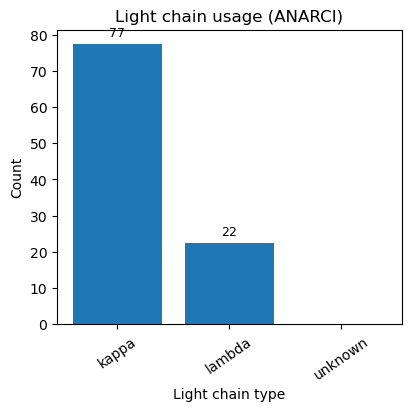

H1 length n=1442 | min/median/p95/max: 3/7/9/18
H2 length n=1442 | min/median/p95/max: 4/6/7/11
H3 length n=1442 | min/median/p95/max: 2/12/20/23
L1 length n=1442 | min/median/p95/max: 4/11/17/17
L2 length n=1441 | min/median/p95/max: 1/7/7/12
L3 length n=1442 | min/median/p95/max: 2/9/12/16


In [114]:
M = pd.read_csv(WITH_SEQS, low_memory=False, keep_default_na=False)
print("light_type_anarci counts:\n",
      M["light_type_anarci"].replace({"": "unknown"}).value_counts(dropna=False))

lt = (
    M["light_type_anarci"].astype(str)
      .replace({"": "unknown"})
      .value_counts(normalize=True)
      .reindex(["kappa", "lambda", "unknown"])
      .fillna(0.0)
      .mul(100.0)
)

fig = plt.figure(figsize=(4, 4))
ax = fig.gca()
ax.bar(lt.index, lt.values)
ax.set_ylabel("Fraction (%)")
ax.set_xlabel("Light chain type")
ax.set_title("Light chain usage (ANARCI)")

label_bars(ax, "Light chain usage (ANARCI)", LIGHT_TYPE_COUNTS_PNG, orient="v", show=True)

for label, col in [("H1","h1_seq"),("H2","h2_seq"),("H3","h3_seq"),
                   ("L1","l1_seq"),("L2","l2_seq"),("L3","l3_seq")]:
    if col in M.columns:
        L = M[col].astype(str).replace({"nan":""}).str.len()
        L = L[L>0]
        if not L.empty:
            print(f"{label} length n={len(L)} | min/median/p95/max: "
                  f"{int(L.min())}/{int(L.median())}/{int(L.quantile(.95))}/{int(L.max())}")

In [115]:
M = pd.read_csv(WITH_SEQS, low_memory=False, keep_default_na=False)

M["_fv"] = M["vh_seq"].astype(str) + "|" + M["vl_seq"].astype(str)

by_pdb = (M.groupby("pdb_id")
            .agg(n=("id","size"),
                 unique_fv=("_fv","nunique"))
            .reset_index()
            .sort_values(["n","unique_fv"], ascending=False))
display(by_pdb.head(25))

dup_fv = (M.groupby("_fv")
            .agg(n=("id","size"),
                 ids=("id", lambda x: list(sorted(set(x)))),
                 pdbs=("pdb_id", lambda x: list(sorted(set(x)))))
            .reset_index()
            .sort_values("n", ascending=False))
dup_fv_multi = dup_fv[dup_fv["n"]>1]
print("Exact Fv duplicate clusters:", len(dup_fv_multi))
display(dup_fv_multi.head(25))

,pdb_id,n,unique_fv
659,8VS8,12,2
120,7U64,9,1
755,9CMC,8,2
201,7WQV,8,1
457,8HRD,7,3
21,7QT0,6,1
514,8R4O,6,1
515,8R4Q,6,1
720,9AXN,6,1
845,9LUX,6,1


Exact Fv duplicate clusters: 342


,_fv,n,ids,pdbs
100,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYVHWVKQRPEQGLE...,21,"[7TCT_EF, 7TD8_EF, 7THO_EF, 7TMZ_EF, 7TPD_EF, ...","[7TCT, 7TD8, 7THO, 7TMZ, 7TPD, 7U60, 7U9F, 7U9..."
253,EVQLVESGGGLVQPGGSLRLSCAASGFYISYSSIHWVRQAPGKGLE...,19,"[7SZU_HL, 7U0Y_HL, 8DP3_HL, 8SH5_HL, 8VM8_HL, ...","[7SZU, 7U0Y, 8DP3, 8SH5, 8VM8, 8VM9, 8VMA, 8VM..."
332,EVQLVQSGAGVKKPGSSVKVSCKSSGGTSGSSAVSWIRQAPGQGVE...,16,"[8R4O_BB, 8R4O_DD, 8R4O_FF, 8R4O_HH, 8R4O_JJ, ...","[8R4O, 8R4Q, 8R4U]"
200,EVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIHWVRQAPGKGLE...,10,"[7T97_AB, 7T97_CD, 7T97_EF, 7T99_AB, 7T99_CD, ...","[7T97, 7T99, 8TI4, 8TJF, 9N8Q]"
408,QVLLVESGGGVVQPGTSLRLSCVASGFSFSTYGMHWVRQSPGKGLE...,10,"[8F95_AB, 8F95_HL, 8F9E_AB, 8F9E_HL, 8F9F_AB, ...","[8F95, 8F9E, 8F9F, 8F9S, 8F9T]"
252,EVQLVESGGGLVQPGGSLRLSCAASGFYISYSSIHWVRQAPGKGLE...,10,"[8D29_AB, 8D29_DE, 8D29_GI, 8D29_HL, 8DK7_BA, ...","[8D29, 8DK7, 8UIW, 9DN4]"
92,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,9,"[7U64_AB, 7U64_CD, 7U64_EF, 7U64_GH, 7U64_IJ, ...",[7U64]
132,EVQLVESGGGFVQPGGSLRLSCAASGFTFSNFDMHWVRQSPGKGLE...,8,"[8D9Y_BA, 8D9Y_DC, 8D9Y_FE, 8D9Y_HG, 8D9Z_BA, ...","[8D9Y, 8D9Z, 8DA0, 8DA1]"
635,QVQLVQSGAEVKKPGSSVKVSCKASGGTFSSYTISWVRQAPGQGLE...,8,"[7WQV_BB, 7WQV_DD, 7WQV_FF, 7WQV_HH, 7WQV_JJ, ...",[7WQV]
224,EVQLVESGGGLVQPGGSLRLSCAASGFTFSDYYMYWVRQAPGKGLE...,8,"[8JEL_CD, 8JEL_FG, 8JEL_IK, 8JEN_AB, 8JEN_CD, ...","[8JEL, 8JEN, 8JEP]"


In [116]:
M = pd.read_csv(PAIRS_WITHSEQS, low_memory=False, keep_default_na=False).copy()
M["_fv"] = M["vh_seq"].astype(str) + "|" + M["vl_seq"].astype(str)
M["_res"] = pd.to_numeric(M["resolution_A"], errors="coerce")
M["_dep"] = pd.to_datetime(M["dep_date"], errors="coerce")

collapsed = (M.sort_values(["pdb_id","_fv","_res","_dep"], ascending=[True,True,True,False])
               .drop_duplicates(["pdb_id","_fv"], keep="first")
               .drop(columns=["_res","_dep"]))
print("Collapsed within-PDB exact-Fv: ", len(collapsed), "rows (was", len(M), ")")
collapsed.to_csv(WITHIN_PDB_EXACT_CSV, index=False)
print("wrote within-PDB exact-Fv reps to:", WITHIN_PDB_EXACT_CSV)

Collapsed within-PDB exact-Fv:  951 rows (was 1442 )
wrote within-PDB exact-Fv reps to: /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/exports/within_pdb_exact.csv


In [117]:
M_exact = pd.read_csv(WITHIN_PDB_EXACT_CSV, low_memory=False, keep_default_na=False)

CDR_COLS = [
    "cdr_h1_start","cdr_h1_end","h1_seq",
    "cdr_h2_start","cdr_h2_end","h2_seq",
    "cdr_h3_start","cdr_h3_end","h3_seq",
    "cdr_l1_start","cdr_l1_end","l1_seq",
    "cdr_l2_start","cdr_l2_end","l2_seq",
    "cdr_l3_start","cdr_l3_end","l3_seq",
    "numbering_scheme",
]
for c in CDR_COLS:
    if c not in M.columns:
        if c.endswith("_seq") or c == "numbering_scheme":
            M[c] = ""
        else:
            M[c] = pd.NA

def _annotate_side(seq: str) -> dict:
    s = str(seq or "")
    if not s:
        return {}
    try:
        ann = annotate_cdrs_anarci(s, scheme="chothia")
    except Exception:
        return {}
    keep = {"numbering_scheme","cdr_h1_start","cdr_h1_end","h1_seq",
            "cdr_h2_start","cdr_h2_end","h2_seq",
            "cdr_h3_start","cdr_h3_end","h3_seq",
            "cdr_l1_start","cdr_l1_end","l1_seq",
            "cdr_l2_start","cdr_l2_end","l2_seq",
            "cdr_l3_start","cdr_l3_end","l3_seq"}
    return {k: ann.get(k, pd.NA) for k in keep}

H_rows, L_rows = [], []
for _, r in M_exact.iterrows():
    H_rows.append(_annotate_side(r.get("vh_seq", "")))
    L_rows.append(_annotate_side(r.get("vl_seq", "")))

H = pd.DataFrame(H_rows).reset_index(drop=True)
L = pd.DataFrame(L_rows).reset_index(drop=True)

for c in H.columns:
    if c.startswith("cdr_h") or c in {"h1_seq","h2_seq","h3_seq","h3_len"} or c == "numbering_scheme":
        M_exact[c] = H[c]

for c in L.columns:
    if c.startswith("cdr_l") or c in {"l1_seq","l2_seq","l3_seq"}:
        M_exact[c] = L[c]
    elif c == "numbering_scheme":
        # prefer a 'chothia' label if L provides it; otherwise keep whatever is already there (possibly from H)
        orig = M_exact.get(c, pd.Series([""]*len(M_exact)))
        cand = L[c].astype(str)
        M_exact[c] = np.where(
            cand.str.lower().str.contains("chothia", na=False), cand,
            np.where(orig.astype(str).str.len() > 0, orig, cand)
        )

M_exact.to_csv(WITHIN_PDB_EXACT_CSV, index=False)
print(f"updated {WITHIN_PDB_EXACT_CSV} with CDRs (rows={len(M_exact)})")

updated /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/exports/within_pdb_exact.csv with CDRs (rows=951)


### Redundancy snapshot with mmseqs2 @ 95%

In [118]:
logs_dir = EXP_DIR / "logs"
logs_dir.mkdir(parents=True, exist_ok=True)

mmseqs_bin = shutil.which("mmseqs")
if not mmseqs_bin:
    raise RuntimeError("mmseqs not found in PATH. Activate env or install MMseqs2.")

threads = max(1, (os.cpu_count() or 2) - 1)

vh_fa = EXP_DIR / "vh.fasta"
vl_fa = EXP_DIR / "vl.fasta"

pairs_exact = pd.read_csv(WITHIN_PDB_EXACT_CSV, low_memory=False, keep_default_na=False)

pairs_exact = pairs_exact[
    (pairs_exact["vh_seq"].astype(str).str.len() > 0) &
    (pairs_exact["vl_seq"].astype(str).str.len() > 0)
].copy()

print(f"WITHIN_PDB_EXACT_CSV rows: {len(pairs_exact)}")

vh_fa.parent.mkdir(parents=True, exist_ok=True)
with open(vh_fa, "w") as fvh, open(vl_fa, "w") as fvl:
    for _, r in pairs_exact.iterrows():
        rid = str(r["id"])
        fvh.write(f">{rid}\n{r['vh_seq']}\n")
        fvl.write(f">{rid}\n{r['vl_seq']}\n")

def _count_fasta_records(fasta_path: Path) -> int:
    n = 0
    with open(fasta_path, "r", encoding="utf-8", errors="ignore") as fh:
        for ln in fh:
            if ln.startswith(">"):
                n += 1
    return n

print(f"{vh_fa} (records={_count_fasta_records(vh_fa)})")
print(f"{vl_fa} (records={_count_fasta_records(vl_fa)})")

def run(cmd: list[str], log_name: str | None = None, cwd: Path | None = None):
    log_path = (logs_dir / log_name) if log_name else (logs_dir / "mmseqs.log")
    log_path.parent.mkdir(parents=True, exist_ok=True)
    header = f"$ {' '.join(cmd)}\n"
    with open(log_path, "w", encoding="utf-8") as lf:
        lf.write(header)
        lf.flush()
        proc = subprocess.run(
            cmd,
            stdout=lf,
            stderr=subprocess.STDOUT,
            cwd=str(cwd) if cwd else None,
            check=False
        )
    if proc.returncode != 0:
        raise RuntimeError(f"Command failed (exit {proc.returncode}). See log: {log_path}")
    return log_path

def mmseqs_cluster_at(fa_path: Path, out_tsv: Path, min_seq_id: float):
    if not shutil.which("mmseqs"):
        raise RuntimeError("mmseqs not found in PATH. Activate env or install MMseqs2.")

    if _count_fasta_records(fa_path) < 1:
        out_tsv.write_text("")
        return out_tsv

    workdir = Path(tempfile.mkdtemp(prefix="ab_mmseqs_", dir=None))
    try:
        base = workdir / (fa_path.stem + "_db")
        base_str = str(base)
        fa_str = str(fa_path)

        run([mmseqs_bin, "createdb", fa_str, base_str, "--threads", str(threads)],
            f"db_{fa_path.name}_id{int(min_seq_id*100)}.log")

        tmp_dir = tempfile.mkdtemp(prefix="mm_tmp_", dir=str(workdir))
        try:
            run(
                [
                    mmseqs_bin, "linclust",
                    base_str, f"{base_str}_clu", tmp_dir,
                    "--min-seq-id", f"{min_seq_id:.2f}",
                    "--cov-mode", "1", "-c", "0.9",
                    "--kmer-per-seq", "80",
                    "--threads", str(threads),
                ],
                f"linclust_{fa_path.name}_id{int(min_seq_id*100)}.log",
            )
        finally:
            shutil.rmtree(tmp_dir, ignore_errors=True)

        tsv_tmp = workdir / (fa_path.stem + f"_id{int(min_seq_id*100)}.tsv")
        run(
            [mmseqs_bin, "createtsv", base_str, base_str, f"{base_str}_clu", str(tsv_tmp)],
            f"tsv_{fa_path.name}_id{int(min_seq_id*100)}.log",
        )

        out_tsv.parent.mkdir(parents=True, exist_ok=True)
        shutil.move(str(tsv_tmp), str(out_tsv))
        return out_tsv
    finally:
        shutil.rmtree(workdir, ignore_errors=True)

def _summarize_clusters(tsv: Path) -> dict:
    if not tsv.exists() or tsv.stat().st_size == 0:
        return {"clusters": 0, "members": 0, "pct_multi_member": 0.0, "largest_cluster": 0}
    m = pd.read_csv(tsv, sep="\t", header=None, names=["rep","mem"])
    m["rep"] = m["rep"].astype(str).str.lstrip(">")
    m["mem"] = m["mem"].astype(str).str.lstrip(">")
    counts = m["rep"].value_counts()
    members = len(m)
    pct_multi = (m["rep"].isin(counts[counts>1].index)).mean() * 100.0 if members else 0.0
    return {
        "clusters": int(counts.shape[0]),
        "members": int(members),
        "pct_multi_member": round(pct_multi, 1),
        "largest_cluster": int(counts.max()) if not counts.empty else 0,
    }

vh90 = EXP_DIR / "vh_90.tsv"
vh95 = EXP_DIR / "vh_95.tsv"
vl90 = EXP_DIR / "vl_90.tsv"
vl95 = EXP_DIR / "vl_95.tsv"

mmseqs_cluster_at(vh_fa, vh90, 0.90)
mmseqs_cluster_at(vh_fa, vh95, 0.95)
mmseqs_cluster_at(vl_fa, vl90, 0.90)
mmseqs_cluster_at(vl_fa, vl95, 0.95)

sum_vh90 = _summarize_clusters(vh90)
sum_vh95 = _summarize_clusters(vh95)
sum_vl90 = _summarize_clusters(vl90)
sum_vl95 = _summarize_clusters(vl95)

summary = pd.DataFrame([
    {"chain":"VH","thr":"90%","clusters":sum_vh90["clusters"],"members":sum_vh90["members"],
     "pct_multi_member":sum_vh90["pct_multi_member"],"largest_cluster":sum_vh90["largest_cluster"]},
    {"chain":"VH","thr":"95%","clusters":sum_vh95["clusters"],"members":sum_vh95["members"],
     "pct_multi_member":sum_vh95["pct_multi_member"],"largest_cluster":sum_vh95["largest_cluster"]},
    {"chain":"VL","thr":"90%","clusters":sum_vl90["clusters"],"members":sum_vl90["members"],
     "pct_multi_member":sum_vl90["pct_multi_member"],"largest_cluster":sum_vl90["largest_cluster"]},
    {"chain":"VL","thr":"95%","clusters":sum_vl95["clusters"],"members":sum_vl95["members"],
     "pct_multi_member":sum_vl95["pct_multi_member"],"largest_cluster":sum_vl95["largest_cluster"]},
])

summary["delta_vs_90"] = summary.groupby("chain")["clusters"].transform(lambda s: s - s.iloc[0])
print(summary)

summary.to_csv(EXP_DIR / "redundancy_one_liner.csv", index=False)
print("wrote:", EXP_DIR / "redundancy_one_liner.csv")
print("files:")
print(" ", vh90)
print(" ", vh95)
print(" ", vl90)
print(" ", vl95)

WITHIN_PDB_EXACT_CSV rows: 951
/Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/exports/vh.fasta (records=951)
/Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/exports/vl.fasta (records=951)
  chain  thr  clusters  members  pct_multi_member  largest_cluster  \
0    VH  90%       651      951              47.7               21   
1    VH  95%       682      951              43.1               21   
2    VL  90%       458      951              69.8               22   
3    VL  95%       610      951              52.9               21   

   delta_vs_90  
0            0  
1           31  
2            0  
3          152  
wrote: /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/exports/redundancy_one_liner.csv
files:
  /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/exports/vh_90.tsv
  /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/ex

In [119]:
reps_path = EXP_DIR / "fv_pairs_nonredundant_95.csv"
vh_tsv = EXP_DIR / "vh_95.tsv"
vl_tsv = EXP_DIR / "vl_95.tsv"

def _load_map(tsv_path: Path, rep_col: str):
    if not tsv_path.exists() or tsv_path.stat().st_size == 0:
        return pd.DataFrame(columns=[rep_col, "id"])
    m = pd.read_csv(tsv_path, sep="\t", header=None, names=["rep","mem"])
    m["rep"] = m["rep"].astype(str).str.lstrip(">")
    m["mem"] = m["mem"].astype(str).str.lstrip(">")
    return m.rename(columns={"rep": rep_col, "mem": "id"})

vh_map = _load_map(vh_tsv, "vh_rep")
vl_map = _load_map(vl_tsv, "vl_rep")

pairs = pd.read_csv(WITHIN_PDB_EXACT_CSV, low_memory=False, keep_default_na=False)
pairs = pairs[(pairs["vh_seq"].astype(str).str.len() > 0) &
              (pairs["vl_seq"].astype(str).str.len() > 0)].copy()

lab = (pairs[["id","pdb_id","resolution_A","dep_date"]]
       .merge(vh_map, on="id", how="left")
       .merge(vl_map, on="id", how="left"))

lab["pair_cluster"] = lab["vh_rep"].fillna(lab["id"]) + "||" + lab["vl_rep"].fillna(lab["id"])

if not reps_path.exists():
    tmp = (lab.assign(_res=pd.to_numeric(lab["resolution_A"], errors="coerce"),
                      _dep=pd.to_datetime(lab["dep_date"], errors="coerce"))
              .sort_values(["pair_cluster","_res","_dep"], ascending=[True, True, False]))
    reps = (tmp.groupby("pair_cluster", as_index=False)
               .first()[["pair_cluster","id"]]
               .rename(columns={"id":"chosen_rep_id"}))
    reps.to_csv(reps_path, index=False)
else:
    reps = pd.read_csv(reps_path, low_memory=False)

members = lab.merge(
    reps[["pair_cluster","chosen_rep_id"]],
    on="pair_cluster", how="left"
)

members["is_chosen_rep"]    = members["id"] == members["chosen_rep_id"]
members["is_mmseqs_rep_vh"] = members["id"] == members["vh_rep"]
members["is_mmseqs_rep_vl"] = members["id"] == members["vl_rep"]

members_cols = [
    "pair_cluster","id","pdb_id","resolution_A","dep_date",
    "is_chosen_rep","is_mmseqs_rep_vh","is_mmseqs_rep_vl"
]

members.sort_values(
    ["pair_cluster","is_chosen_rep","resolution_A","dep_date"],
    ascending=[True, False, True, False]
)[members_cols].to_csv(EXP_DIR / "cluster_membership_fv95.csv", index=False)

summary = (members.groupby("pair_cluster", as_index=False)
                  .agg(size=("id","size"),
                       chosen_rep_id=("chosen_rep_id","first"))
                  .assign(redundant=lambda d: d["size"] > 1)
                  .sort_values(["size","pair_cluster"], ascending=[False, True]))
summary.to_csv(EXP_DIR / "cluster_summary_fv95.csv", index=False)

print("wrote membership & summary (per-chain clustering @95%)")

wrote membership & summary (per-chain clustering @95%)


In [120]:
reps_path = EXP_DIR / "fv_pairs_nonredundant_95.csv"
reps = pd.read_csv(reps_path, low_memory=False)
KEEP_CDR_WEIRD_IN_FINAL = True
_base_final = pd.read_csv(PAIRS_WITHSEQS, low_memory=False, keep_default_na=False)
final_nr = _base_final.merge(
    reps.rename(columns={"chosen_rep_id": "id"})[["id"]],
    on="id", how="inner"
)

if "_ultra_short" in final_nr.columns:
    mask_ultra = final_nr["_ultra_short"].astype(bool).fillna(False)
else:
    mask_ultra = pd.Series(False, index=final_nr.index)

_final = final_nr[~mask_ultra].copy()
_final.to_csv(PAIRS_FINAL, index=False)
print(f"wrote non-redundant benchmark dataset to: {PAIRS_FINAL} (n={len(_final)})")

wrote non-redundant benchmark dataset to: /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/exports/pairs_qc_pass_ultrashort_pruned (n=698)


In [121]:
assert isinstance(mask_ultra, pd.Series) and mask_ultra.dtype == bool and len(mask_ultra) == len(final_nr)
assert set(_final["id"]).issubset(set(final_nr.loc[~mask_ultra, "id"]))
print("NR rows:", len(_final))

NR rows: 698


In [122]:
def getcol(df, name, default=""):
    return df[name] if name in df.columns else pd.Series([default]*len(df), index=df.index)

if "light_type_anarci" in M.columns:
    bad_light = ~getcol(M, "light_type_anarci").fillna("").isin(["kappa","lambda","","unknown"])
else:
    bad_light = pd.Series([False]*len(M), index=M.index)

vh_empty = getcol(M, "vh_seq").fillna("").eq("")

print("HL type anomalies:", int(bad_light.sum()))
print("VH empty while VL present:", int((vh_empty & getcol(M, "vl_seq").fillna("").ne("")).sum()))

method_ok = getcol(M, "exp_method").astype(str).str.strip().str.lower().eq("x-ray diffraction")
res_num   = pd.to_numeric(getcol(M, "resolution_A"), errors="coerce")
res_ok    = res_num.le(MAX_RESOLUTION_XRAY)

print("Non X-ray retained:", int((~method_ok).sum()))
print(f"Resolution >{MAX_RESOLUTION_XRAY}A retained:", int((~res_ok).sum()))

print("rows INPUT:", len(M))
mask_both = (getcol(M,"vh_seq").astype(str).str.len()>0) & (getcol(M,"vl_seq").astype(str).str.len()>0)
print("pairs (both seqs):", int(mask_both.sum()))

try:
    print(POLICY_BANNER)
except NameError:
    print(
        f"Policy: X-ray only; max resolution {MAX_RESOLUTION_XRAY:.1f} Å; "
        f"paired VH/VL={REQUIRE_PAIRED}; strict ANARCI={STRICT_ANARCI_ONLY}; "
        f"CDR scheme={'Chothia' if CHOTHIA_ONLY else 'mixed'}; "
        f"allow_cryo_em={ALLOW_CRYO_EM}"
    )

if "light_type_anarci" in M.columns:
    print("\nlight_type_anarci (all rows):")
    print(getcol(M,"light_type_anarci").replace({"": "unknown"}).value_counts(dropna=False).to_string())
else:
    print("\nlight_type_anarci: n/a (column not present)")

if "numbering_scheme" in M.columns:
    print("\nnumbering_scheme (as stored):")
    print(getcol(M,"numbering_scheme").replace({pd.NA:""}).replace({"": "unknown"}).value_counts(dropna=False).to_string())
else:
    print("\nnumbering_scheme: n/a (column not present)")

if "h3_len" in M.columns:
    h3 = pd.to_numeric(getcol(M,"h3_len"), errors="coerce").dropna()
    if not h3.empty:
        print(f"\nH3 length: n={len(h3)} | min/median/p95/max: "
              f"{int(h3.min())}/{int(h3.median())}/{int(h3.quantile(.95))}/{int(h3.max())}")
else:
    print("\nH3 length: n/a (column not present)")

try:
    reps90    = pd.read_csv(EXP_DIR/"fv_pairs_nonredundant_90.csv")
    summary90 = pd.read_csv(EXP_DIR/"cluster_summary_fv90.csv")
    print("Fv@90% (per-chain): clusters:", len(summary90),
          "| multi-member:", int((summary90['size']>1).sum()),
          "| reps:", len(reps90))
except Exception:
    print("Fv@90% snapshot not found (run the MMseqs step first).")

M.to_csv(PAIRS_WITHSEQS_QC, index=False)
print("QC copy written:", PAIRS_WITHSEQS_QC)

same_nonempty = (M["vh_seq"].astype(str).str.len() > 0) & \
                (M["vl_seq"].astype(str).str.len() > 0) & \
                (M["vh_seq"] == M["vl_seq"])
print("VH==VL (non-empty):", int(same_nonempty.sum()))

need_cols = ["h1_seq","h2_seq","h3_seq","l1_seq","l2_seq","l3_seq","h3_len"]
missing = [c for c in need_cols if c not in M.columns]
print("Missing annotation cols:", missing)

HL type anomalies: 0
VH empty while VL present: 0
Non X-ray retained: 0
Resolution >3.0A retained: 0
rows INPUT: 1442
pairs (both seqs): 1442
Policy: X-ray only; max resolution 3.0 Å; paired VH/VL=True; strict ANARCI=True; CDR scheme=Chothia; allow_cryo_em=False

light_type_anarci (all rows):
light_type_anarci
kappa     1118
lambda     324

numbering_scheme (as stored):
numbering_scheme
chothia    1442

H3 length: n=1442 | min/median/p95/max: 2/12/20/23
Fv@90% snapshot not found (run the MMseqs step first).
QC copy written: /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/exports/pairs_withseqs_qc.csv
VH==VL (non-empty): 0
Missing annotation cols: []


In [123]:
SRC_PAIRS = WITHIN_PDB_EXACT_CSV
M = pd.read_csv(SRC_PAIRS, low_memory=False, keep_default_na=False)

def getcol(df, name, default=""):
    return df[name] if name in df.columns else pd.Series([default]*len(df), index=df.index)

if "light_type_anarci" in M.columns:
    bad_light = ~getcol(M, "light_type_anarci").fillna("").isin(["kappa","lambda","","unknown"])
else:
    bad_light = pd.Series([False]*len(M), index=M.index)

vh_empty = getcol(M, "vh_seq").fillna("").eq("")

print("HL type anomalies:", int(bad_light.sum()))
print("VH empty while VL present:", int((vh_empty & getcol(M, "vl_seq").fillna("").ne("")).sum()))

method_ok = getcol(M, "exp_method").astype(str).str.strip().str.lower().eq("x-ray diffraction")
res_num   = pd.to_numeric(getcol(M, "resolution_A"), errors="coerce")
res_ok    = res_num.le(MAX_RESOLUTION_XRAY)

print("Non X-ray retained:", int((~method_ok).sum()))
print(f"Resolution >{MAX_RESOLUTION_XRAY}A retained:", int((~res_ok).sum()))

print("rows INPUT:", len(M))
mask_both = (getcol(M,"vh_seq").astype(str).str.len()>0) & (getcol(M,"vl_seq").astype(str).str.len()>0)
print("pairs (both seqs):", int(mask_both.sum()))

try:
    print(POLICY_BANNER)
except NameError:
    print(
        f"Policy: X-ray only; max resolution {MAX_RESOLUTION_XRAY:.1f} Å; "
        f"paired VH/VL={REQUIRE_PAIRED}; strict ANARCI={STRICT_ANARCI_ONLY}; "
        f"CDR scheme={'Chothia' if CHOTHIA_ONLY else 'mixed'}; "
        f"allow_cryo_em={ALLOW_CRYO_EM}"
    )

if "light_type_anarci" in M.columns:
    print("\nlight_type_anarci (all rows):")
    print(getcol(M,"light_type_anarci").replace({"": "unknown"}).value_counts(dropna=False).to_string())
else:
    print("\nlight_type_anarci: n/a (column not present)")

if "numbering_scheme" in M.columns:
    print("\nnumbering_scheme (as stored):")
    print(getcol(M,"numbering_scheme").replace({pd.NA:""}).replace({"": "unknown"}).value_counts(dropna=False).to_string())
else:
    print("\nnumbering_scheme: n/a (column not present)")

if "h3_len" in M.columns:
    h3 = pd.to_numeric(getcol(M,"h3_len"), errors="coerce").dropna()
    if not h3.empty:
        print(f"\nH3 length: n={len(h3)} | min/median/p95/max: "
              f"{int(h3.min())}/{int(h3.median())}/{int(h3.quantile(.95))}/{int(h3.max())}")
else:
    print("\nH3 length: n/a (column not present)")

try:
    reps95    = pd.read_csv(EXP_DIR/"fv_pairs_nonredundant_95.csv")
    summary95 = pd.read_csv(EXP_DIR/"cluster_summary_fv95.csv")
    print("Fv@95% (per-chain): clusters:", len(summary95),
          "| multi-member:", int((summary95['size']>1).sum()),
          "| reps:", len(reps95))
except Exception:
    print("Fv@95% snapshot not found (run/build the 95% reps first).")

M.to_csv(PAIRS_WITHSEQS_QC, index=False)
print("QC copy written:", PAIRS_WITHSEQS_QC)

same_nonempty = (M["vh_seq"].astype(str).str.len() > 0) & \
                (M["vl_seq"].astype(str).str.len() > 0) & \
                (M["vh_seq"] == M["vl_seq"])
print("VH==VL (non-empty):", int(same_nonempty.sum()))

need_cols = ["h1_seq","h2_seq","h3_seq","l1_seq","l2_seq","l3_seq","h3_len"]
missing = [c for c in need_cols if c not in M.columns]
print("Missing annotation cols:", missing)

REDUNDANCY = 0.95
ID_TAG = int(REDUNDANCY * 100)

vh_tsv = EXP_DIR / f"vh_{ID_TAG}.tsv"
vl_tsv = EXP_DIR / f"vl_{ID_TAG}.tsv"
reps_path = EXP_DIR / f"fv_pairs_nonredundant_{ID_TAG}.csv"
members_out = EXP_DIR / f"cluster_membership_fv{ID_TAG}.csv"
summary_out = EXP_DIR / f"cluster_summary_fv{ID_TAG}.csv"

HL type anomalies: 0
VH empty while VL present: 0
Non X-ray retained: 0
Resolution >3.0A retained: 0
rows INPUT: 951
pairs (both seqs): 951
Policy: X-ray only; max resolution 3.0 Å; paired VH/VL=True; strict ANARCI=True; CDR scheme=Chothia; allow_cryo_em=False

light_type_anarci (all rows):
light_type_anarci
kappa     735
lambda    216

numbering_scheme (as stored):
numbering_scheme
chothia    951

H3 length: n=951 | min/median/p95/max: 2/12/20/23
Fv@95% (per-chain): clusters: 698 | multi-member: 133 | reps: 698
QC copy written: /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/exports/pairs_withseqs_qc.csv
VH==VL (non-empty): 0
Missing annotation cols: []


In [58]:
def trace_dataset(msg: str, path: Path):
    if not path.exists():
        print(f"{msg}: MISSING -> {path}")
        return
    d = pd.read_csv(path, low_memory=False, keep_default_na=False)
    vh_cov = (d.get("vh_seq", pd.Series([], dtype=str)).astype(str).str.len() > 0).mean() * 100
    vl_cov = (d.get("vl_seq", pd.Series([], dtype=str)).astype(str).str.len() > 0).mean() * 100
    both_cov = (((d.get("vh_seq", pd.Series([], dtype=str)).astype(str).str.len() > 0) &
                 (d.get("vl_seq", pd.Series([], dtype=str)).astype(str).str.len() > 0))).mean() * 100
    print(f"{msg}: {path.name} rows={len(d)} | vh%={vh_cov:.1f} vl%={vl_cov:.1f} both%={both_cov:.1f}")
    if "vh_seq_source" in d.columns and "vl_seq_source" in d.columns:
        vh_src = d["vh_seq_source"].astype(str).str.split(":").str[0].value_counts().to_dict()
        vl_src = d["vl_seq_source"].astype(str).str.split(":").str[0].value_counts().to_dict()
        print("        sources VH:", vh_src, " | VL:", vl_src)
trace_dataset("AUTHORITATIVE", PAIRS_WITHSEQS)
trace_dataset("AF3_VIEW", PAIRS_AF3_INDEX)
trace_dataset("WITHIN_PDB_EXACT", WITHIN_PDB_EXACT_CSV)
trace_dataset("FINAL_NR", PAIRS_FINAL)

AUTHORITATIVE: pairs_withseqs.csv rows=1442 | vh%=100.0 vl%=100.0 both%=100.0
        sources VH: {'anarci_direct': 1442}  | VL: {'anarci_direct': 1442}
AF3_VIEW: pairs_af3.csv rows=1642 | vh%=nan vl%=nan both%=nan
WITHIN_PDB_EXACT: within_pdb_exact.csv rows=951 | vh%=100.0 vl%=100.0 both%=100.0
        sources VH: {'anarci_direct': 951}  | VL: {'anarci_direct': 951}
FINAL_NR: pairs_qc_pass_ultrashort_pruned.csv rows=698 | vh%=100.0 vl%=100.0 both%=100.0
        sources VH: {'anarci_direct': 698}  | VL: {'anarci_direct': 698}


In [59]:
assert PAIRS_FINAL.exists(), f"PAIRS_FINAL not found: {PAIRS_FINAL}"
M0 = pd.read_csv(PAIRS_FINAL, low_memory=False, keep_default_na=False)
print(f"Source = {PAIRS_FINAL} | rows={len(M0)} | ids_unique={M0['id'].is_unique if 'id' in M0.columns else 'n/a'}")

Source = /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/exports/pairs_qc_pass_ultrashort_pruned.csv | rows=698 | ids_unique=True


In [124]:
AA20 = set("ACDEFGHIKLMNPQRSTVWY")
PAIRS_WITHSEQS = MAN_DIR / "pairs_withseqs.csv"
PAIRS_AF3_INDEX = MAN_DIR / "pairs_af3.csv"
WITHIN_PDB_EXACT = EXP_DIR / "within_pdb_exact.csv"
PAIRS_FINAL = EXP_DIR / "pairs_qc_pass_ultrashort_pruned"

pw  = pd.read_csv(PAIRS_WITHSEQS, low_memory=False, keep_default_na=False)
wpe = pd.read_csv(WITHIN_PDB_EXACT, low_memory=False, keep_default_na=False)
M0  = pd.read_csv(PAIRS_FINAL, low_memory=False, keep_default_na=False)

for name, df in [("pairs_withseqs", pw), ("within_pdb_exact", wpe), ("FINAL_NR", M0)]:
    assert df["vh_seq_source"].astype(str).str.startswith("anarci_direct").all(), f"{name}: VH not strict"
    assert df["vl_seq_source"].astype(str).str.startswith("anarci_direct").all(), f"{name}: VL not strict"

for name, df, min_rows in [("pairs_withseqs", pw, 100), ("within_pdb_exact", wpe, 100), ("FINAL_NR", M0, 100)]:
    assert {"vh_seq","vl_seq","vh_seq_source","vl_seq_source"}.issubset(df.columns), f"{name}: missing seq columns"
    assert (df["vh_seq_source"].astype(str).str.startswith("anarci_direct")).all(), f"{name}: VH not strict"
    assert (df["vl_seq_source"].astype(str).str.startswith("anarci_direct")).all(), f"{name}: VL not strict"
    if len(df) < min_rows:
        raise AssertionError(f"{name}: too few rows ({len(df)}) — check upstream filters/downloads.")

for df_name, df in [("pairs_withseqs", pw), ("within_pdb_exact", wpe), ("FINAL_NR", M0)]:
    for col in ("vh_seq","vl_seq","vh_seq_source","vl_seq_source"):
        if col not in df.columns:
            raise KeyError(f"{df_name} missing `{col}`")

    assert df["vh_seq_source"].astype(str).str.startswith("anarci_direct").all(), f"{df_name}: VH not all strict"
    assert df["vl_seq_source"].astype(str).str.startswith("anarci_direct").all(), f"{df_name}: VL not all strict"

def _cov(d):
    vh = (d["vh_seq"].astype(str).str.len() > 0).mean()*100
    vl = (d["vl_seq"].astype(str).str.len() > 0).mean()*100
    both = (((d["vh_seq"].astype(str).str.len()>0)&(d["vl_seq"].astype(str).str.len()>0))).mean()*100
    return vh, vl, both

print("[pairs_withseqs]", len(pw), "cov:", tuple(round(x,1) for x in _cov(pw)))
print("[within_pdb_exact]", len(wpe), "cov:", tuple(round(x,1) for x in _cov(wpe)))
print("[FINAL_NR]", len(M0), "cov:", tuple(round(x,1) for x in _cov(M0)))

[pairs_withseqs] 1442 cov: (np.float64(100.0), np.float64(100.0), np.float64(100.0))
[within_pdb_exact] 951 cov: (np.float64(100.0), np.float64(100.0), np.float64(100.0))
[FINAL_NR] 698 cov: (np.float64(100.0), np.float64(100.0), np.float64(100.0))


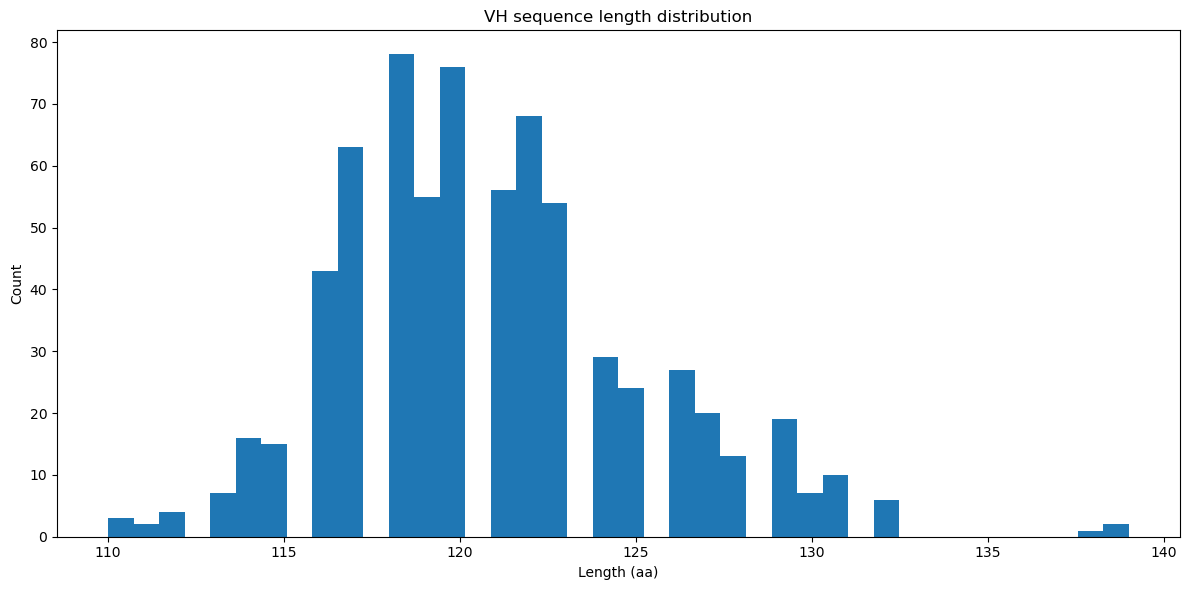

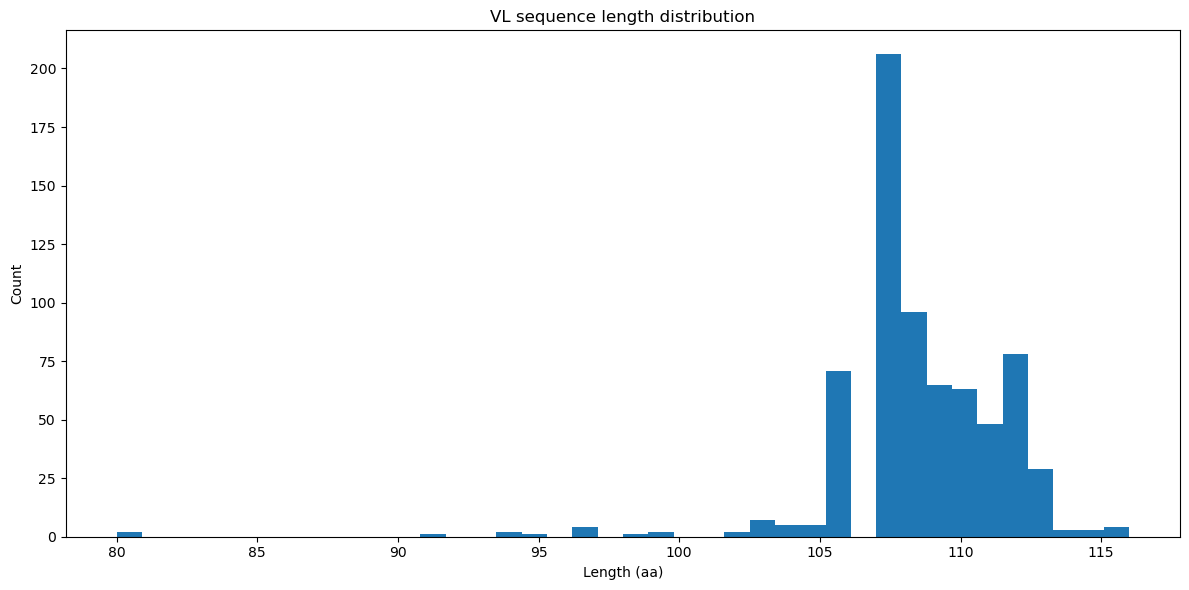

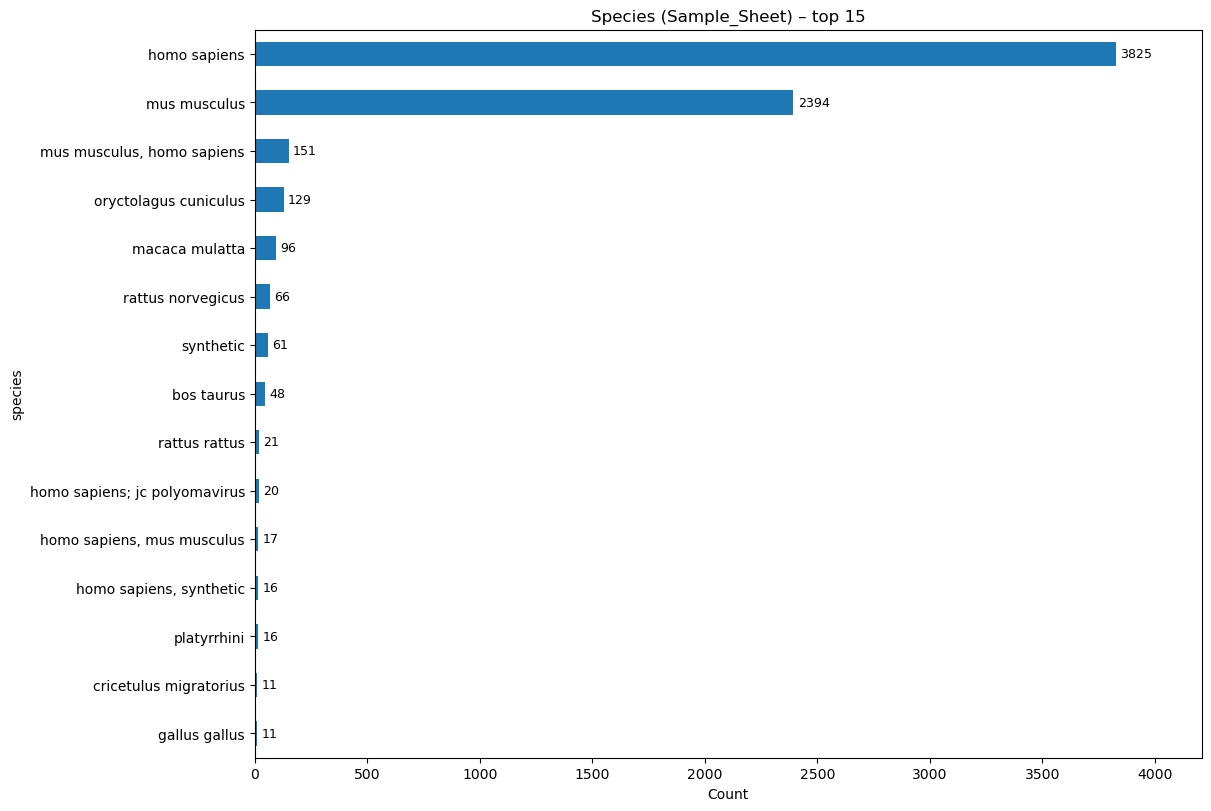

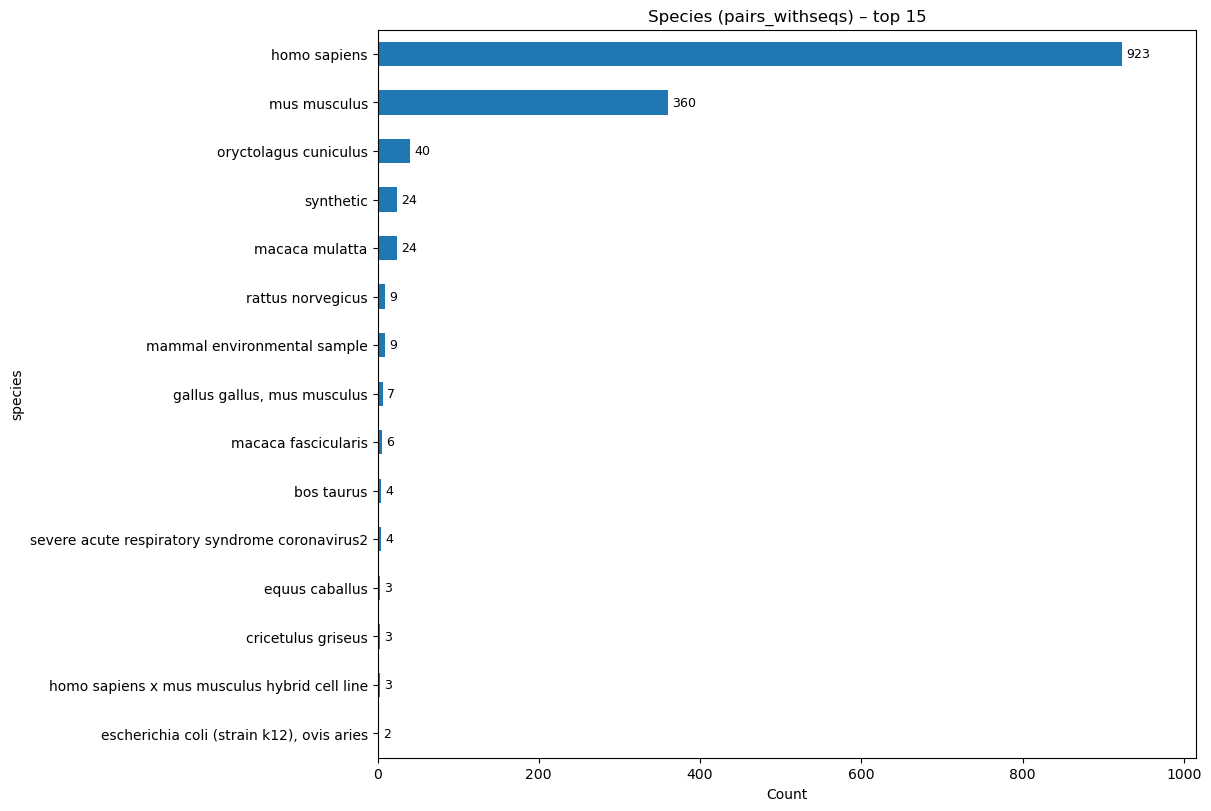

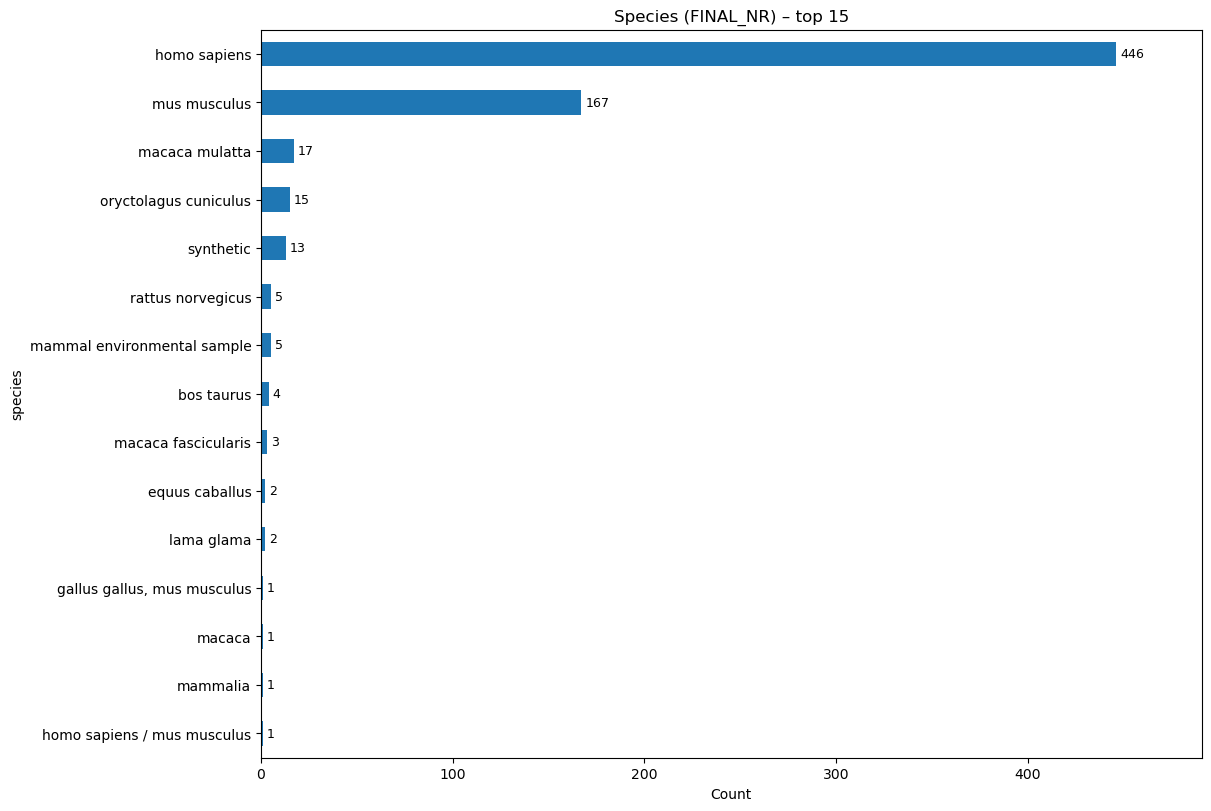

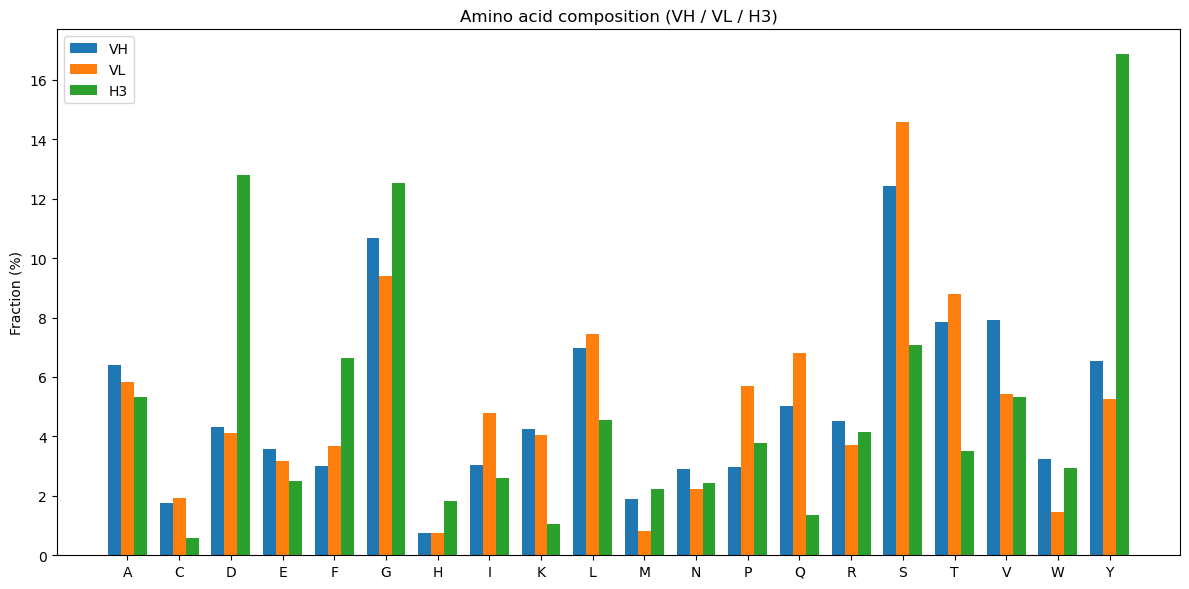

Saved: /Users/tinaganjipour/Documents/UMCU/2. The project/ab-difficulty/data/processed/exports/plots/aa_composition_labeled.png
H3 length summary: {'n': 698, 'min': 2, 'median': 12.0, 'p95': 20.0, 'max': 23}
species_* .csv/.png, aa_composition.csv/plot, h3_length_summary.csv/plot written.


In [125]:
def plot_len_hist(
    series: pd.Series,
    title: str,
    out_png: Path,
    bins: int = 40,
    min_len: Optional[int] = None,
):
    L = series.fillna("").astype(str).str.len()
    if min_len is not None:
        L = L[L >= int(min_len)]
    if L.empty:
        print(f"No data for {title}")
        return
    fig = plt.figure(figsize=(12, 6))
    ax = fig.gca()
    ax.hist(L, bins=bins)
    ax.set_title(title)
    ax.set_xlabel("Length (aa)")
    ax.set_ylabel("Count")
    fig.tight_layout()
    save_and_show(fig, out_png)

def species_top(df, label):
    import re
    norm_map = {
        r"\bsynthetic construct\b": "synthetic",
        r"^environmental sample.*": "environmental sample",
        r"\bhomo sapiens\b": "homo sapiens",
        r"\bmus musculus\b": "mus musculus",
        r"\bbos taurus\b": "bos taurus",
        r"\boryctolagus cuniculus\b": "oryctolagus cuniculus",
        r"\brattus norvegicus\b": "rattus norvegicus",
        r"\bmacaca mulatta\b": "macaca mulatta",
        r"\bcricetulus griseus\b": "cricetulus griseus",
    }
    if "species" not in df.columns:
        print(f"[species] Column 'species' not found in {label}; skipping.")
        return
    s = (df["species"].astype(str).str.strip().str.lower()
           .replace({"": np.nan}).dropna())
    s = s.str.replace(r"\s*/\s*", " / ", regex=True)

    def _normalize_pair(pair: str):
        parts = [p.strip() for p in pair.split(" / ")]
        out = []
        for p in parts:
            q = p
            for pat, repl in norm_map.items():
                q = re.sub(pat, repl, q)
            out.append(q)
        return " / ".join(out)

    s = s.map(_normalize_pair)
    top = s.value_counts().head(15).rename_axis("species").reset_index(name="count")
    top.to_csv(EXP_DIR / f"species_{label}.csv", index=False)

    fig, ax = plt.subplots(figsize=(12, 8))
    top.set_index("species")["count"].sort_values().plot(kind="barh", ax=ax)
    label_bars(ax, f"Species ({label}) – top 15", PLOTS_DIR / f"species_{label}.png", orient="h", show=True)

QC_FAILS_CSV = EXP_DIR / "qc_failures.csv"
OUT_SUMMARY  = EXP_DIR / "dropped_summary_recheck.csv"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

plot_len_hist(M0["vh_seq"], "VH sequence length distribution", PLOTS_DIR / "vh_len_qc.png")
plot_len_hist(M0["vl_seq"], "VL sequence length distribution", PLOTS_DIR / "vl_len_qc.png")

sample_sheet_df = pd.read_csv(SAMPLE_SHEET, low_memory=False, keep_default_na=False)
species_top(sample_sheet_df, "Sample_Sheet")
species_top(pw.assign(species=pw.get("species","")),  "pairs_withseqs")
species_top(M0.assign(species=M0.get("species","")),  "FINAL_NR")

pairs_final_df = M0.copy()
pf_for_comp = pairs_final_df

def _aa_frac(seq_series: pd.Series) -> pd.Series:
    aa = "".join(str(s or "") for s in seq_series)
    total = len(aa) if aa else 0
    counts = {a: 0 for a in "ACDEFGHIKLMNPQRSTVWY"}
    for c in aa:
        u = c.upper()
        if u in counts:
            counts[u] += 1
    if total > 0:
        return pd.Series({k: 100.0 * v / total for k, v in counts.items()})
    else:
        return pd.Series({k: 0.0 for k in counts})

vh_comp = _aa_frac(pf_for_comp["vh_seq"])
vl_comp = _aa_frac(pf_for_comp["vl_seq"])
h3_comp = _aa_frac(pf_for_comp.get("h3_seq", pd.Series([], dtype=str)))

aa_comp = pd.DataFrame({"VH_%": vh_comp, "VL_%": vl_comp, "H3_%": h3_comp})
aa_comp.index.name = "AA"
aa_comp.to_csv(EXP_DIR / "aa_composition.csv")

AA20_order = list("ACDEFGHIKLMNPQRSTVWY")
aa_comp = aa_comp.reindex(AA20_order)

x = np.arange(len(AA20_order)); width = 0.25
fig = plt.figure(figsize=(12, 6))
ax = fig.gca()
ax.bar(x - width, aa_comp["VH_%"].values, width, label="VH")
ax.bar(x,          aa_comp["VL_%"].values, width, label="VL")
ax.bar(x + width,  aa_comp["H3_%"].values, width, label="H3")
ax.set_xticks(x)
ax.set_xticklabels(AA20_order, rotation=0)
ax.set_ylabel("Fraction (%)")
ax.set_title("Amino acid composition (VH / VL / H3)")
ax.legend()
fig.tight_layout()

out_png = PLOTS_DIR / "aa_composition_labeled.png"
fig.savefig(out_png, dpi=200)
plt.show()
plt.close(fig)
print("Saved:", out_png)

def plot_h3_len(df: pd.DataFrame):
    if "h3_len" not in df.columns or df["h3_len"].isna().all():
        print("ERROR: h3_len missing/empty in final dataset. Fix upstream enrichment before plotting.")
        return
    h3 = pd.to_numeric(df["h3_len"], errors="coerce").dropna()
    if h3.empty:
        print("No H3 lengths to plot.")
        return
    stats = {
        "n": int(h3.size),
        "min": int(h3.min()),
        "median": float(h3.median()),
        "p95": float(h3.quantile(0.95)),
        "max": int(h3.max()),
    }
    pd.DataFrame([stats]).to_csv(EXP_DIR / "h3_length_summary.csv", index=False)

    fig = plt.figure(figsize=(12,6))
    ax = fig.gca()
    bins = range(int(h3.min()), int(h3.max()) + 2)
    ax.hist(h3, bins=bins)
    ax.set_title("H3 length distribution")
    ax.set_xlabel("Length")
    ax.set_ylabel("Count")
    fig.tight_layout()
    fig.savefig(PLOTS_DIR / "h3_length_hist.png", dpi=200)
    plt.close(fig)
    print("H3 length summary:", stats)


plot_h3_len(M0)

print("species_* .csv/.png, aa_composition.csv/plot, h3_length_summary.csv/plot written.")

References:
1. Ruffolo et al., 2023: IgFold / deep-learning antibody structure prediction
2. Abanades et al., 2023: ImmuneBuilder
3. Abramson et al., 2024: AlphaFold 3
4. Dunbar et al., 2014: SAbDab (Structural Antibody Database)
5. Dunbar & Deane, 2015: ANARCI
6. Dunbar & Deane, 2016: ANARCI
7. Zhu et al., 2024: Review of antibody numbering schemes
8. Chothia & Lesk, 1987: Canonical CDR structures (foundational)
9. Al-Lazikani et al., 1997: Standard conformations of canonical structures
10. GEMMI (software documentation)
11. Marx, 2026: Nanobodies overview (Nature Methods)